# 4. XRF element detection limits
## Summary
This notebook calculates limits of detection for those deconvoluted and repacked spectra output from the `3_XRF_normalisation_and_repacking` notebook.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import seaborn as sns

from shutil import copyfile
from matplotlib.ticker import ScalarFormatter

import sys
sys.path.insert(0, '..\\code\\')
import high_plex_hdf

Set input and output directories

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'processed' / 'xrf' / '3_norm_repacked_XRF_hdfs'

# Gather filepaths for preprocessed hdfs and config files for XRF fitting
hdf_filepaths = list(input_dir.glob('*.h5'))

# Make output directory segmented images
out_dir = base_dir / 'data' / 'analysis' / 'xrf' / '4_xrf_detection_limits'

out_dir.mkdir(parents=True, exist_ok=True)
print('Detection limits will be output to: \n\t', out_dir) 

# Collect XRF and IMC scan metadata
df_xrf_hdf_files = pd.read_csv(base_dir / 'data' / 'processed' / 'xrf' / '1_reduced_reshaped_hdfs' / 'preprocessed_hdf_config_files.csv')
df_xrf_metadata = pd.read_csv(base_dir / 'data' / 'processed' /  'xrf' / '1_reduced_reshaped_hdfs' / 'xrf_scan_metadata_full.csv')

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')

Detection limits will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\4_xrf_detection_limits


In [3]:
# Get scan names for gelatin standard detection limits
df_detector_standard_scans = df_xrf_metadata[
    (df_xrf_metadata['sample_concentration'].notnull())
    & (df_xrf_metadata['sample_roi'] == 'gelatin centre')
]


In [4]:
df_detector_standard_scans['detector'].unique()

array(['SDD', 'GeCMOS', 'GeCMOS (2nd)'], dtype=object)

In [5]:
# df_detector_standard_scans[df_detector_standard_scans['detector'] == 'GeCMOS (2nd)']

In [6]:
df_example_scans = df_detector_standard_scans[
    (df_detector_standard_scans['sample_concentration'] == 200)
    & (df_detector_standard_scans['dwell_ms'] == 1000)
]

In [7]:
df_example_scans

scan_name sample_name_ref  sample_name       sample_type  \
8           102_t_0001             NaN  sample102_t  gelatin standard   
30  sample102_t_3_0001             NaN  sample102_t  gelatin standard   

        sample_roi    beamline  beamtime scanset  scatter_set  dwell_ms  \
8   gelatin centre  ESRF-ID15A  LS2893_1     NaN            1    1000.0   
30  gelatin centre  ESRF-ID15A  LS2893_3     NaN            7    1000.0   

    step_um  sample_concentration detector  dual_detector AB_panel  \
8       0.5                 200.0      SDD            1.0      NaN   
30      1.0                 200.0   GeCMOS            0.0      NaN   

                          config_file               hdf_file  \
8   21_07_07_SDD_gelatin_ls2893_1.cfg    sample102_t_0001.h5   
30        21_07_07_GeCMOS_gelatin.cfg  sample102_t_3_0001.h5   

                                      hdf_full_fpaths  \
8   C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...   
30  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...   

                                             hdf_path        hdf_filename  
8   C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...    sample102_t_0001  
30  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  sample102_t_3_0001

In [8]:
out_dir

WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/xrf/4_xrf_detection_limits')

In [9]:
example_spectra = {}
for fpath in df_example_scans.hdf_full_fpaths:
    det = df_example_scans.loc[
        df_example_scans['hdf_full_fpaths'] == fpath, 'detector'
    ].iloc[0]
    with h5py.File(fpath, 'r') as hdf:
        # select first 20 spectra for each scan
        example_spectra[det] = hdf['1.1/measurement/falconx_det0'][()][:20, :]  

        

hdf_fpath = out_dir / '20_spectra_per_detector.h5'
with h5py.File(hdf_fpath, 'a') as hdf:
    for det in example_spectra:
        if det in hdf:
            hdf[det][...] = example_spectra[det]
        else:
            hdf[det] = example_spectra[det]
           
print('Example spectra exported to ', hdf_fpath)

Example spectra exported to  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\4_xrf_detection_limits\20_spectra_per_detector.h5


At this point, these spectra are fitted and export to csvs using the PyMCA GUI with their respective config files. These should be output to the `out_dir`, with the names 'SDD_calibrated.csv' and 'GeCMOS_calibrated.csv'

In [10]:
df_sdd_spectra = pd.read_csv(list(out_dir.glob('*SDD_calibrated*.csv'))[0])
df_sdd_spectra['Detector'] = 'SDD'
df_gecmos_spectra = pd.read_csv(list(out_dir.glob('*GeCMOS_calibrated.csv'))[0])
df_gecmos_spectra['Detector'] = 'GeCMOS'
df_gecmos_spectra['counts'] = df_gecmos_spectra['counts']*3.1 # to correct for solid angle
df_select_spectra = pd.concat([df_sdd_spectra, df_gecmos_spectra]).reset_index(drop=True)

C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\4_xrf_detection_limits\Fig1c_Spectra.svg


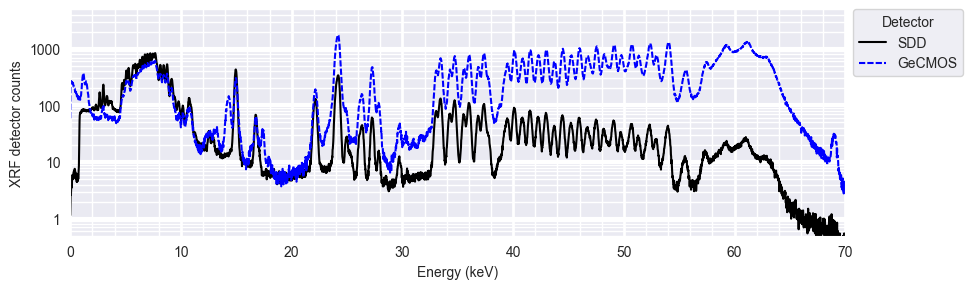

In [11]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,3), dpi=100)
g = sns.lineplot(
    data=df_select_spectra,
    x='energy',
    y='counts',
    hue='Detector',
    style = 'Detector',
    dashes = ['', (3,1)],
    palette=['black', 'blue'],
    ax=ax,
    legend='full'
)

ax.set(yscale="log")
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim([0.5,5000])
#ax.set_yticks(list(range(0.5, 900, 200)))
#ax.set_yticks(list(range(0, 900, 50)), minor=True)

ax.set_xlim([0,70])
ax.set_xticks(list(range(0, 80, 10)))
ax.set_xticks(list(range(0, 70, 2)), minor=True)

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=2, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(title = 'Detector', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Energy (keV)')
plt.ylabel('XRF detector counts')

savename = out_dir / 'Fig1c_Spectra.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')
plt.show()


In [12]:
hdf_fpath = out_dir / '20_spectra_per_detector.h5'

with h5py.File(hdf_fpath, 'a') as hdf:
    for det in example_spectra:
        if det in hdf:
            hdf[det][...] = example_spectra[det]
        else:
            hdf[det] = example_spectra[det]
           
print('Example spectra exported to ', hdf_fpath)

Example spectra exported to  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\4_xrf_detection_limits\20_spectra_per_detector.h5


In [13]:
# Make a dataframe of measurements per concentration for each detector
columns = [
    'detector',
    'element_emission_line', 
    'dwell_ms',
    'concentration_ppm', 
    'img_mean', 
    'img_std', 
    'x_dim', 
    'y_dim',
    'hdf_filepath'    
] 

df_standard_measurements = pd.DataFrame(columns=columns)

for scan in df_detector_standard_scans['hdf_filename']:
    row_dict = dict.fromkeys(columns)
    
    row_metadata = df_detector_standard_scans[
        df_detector_standard_scans['hdf_filename'] == scan
    ]
    
    # Add hdf metadata to row_dict dictionary
    row_dict['hdf_filepath'] = list(input_dir.glob(f'{scan}*.h5'))[0]
    row_dict['concentration_ppm'] = row_metadata['sample_concentration'].iloc[0]
    row_dict['dwell_ms'] = row_metadata['dwell_ms'].iloc[0]
    row_dict['detector'] = row_metadata['detector'].iloc[0]
    
    # Get channel names for hdf
    df_channels = pd.read_hdf(row_dict['hdf_filepath'], key = 'images/df_channel_metadata')
    
    # Get channel data for hdf and add to row_dict dictionary
    with h5py.File(row_dict['hdf_filepath'], 'r') as hdf:
        image_stack = hdf['images/raw'][()]

    for channel in range(image_stack.shape[-1]):
        img = image_stack[:20,:20,channel] # makes image sizes the same for all measures, selects chanels
        assert len(img.shape) == 2      

        row_dict['element_emission_line'] = df_channels['plot_channel'].iloc[channel]
        row_dict['img_mean'] = img.mean()
        row_dict['img_std'] = img.std()
        row_dict['x_dim'] = img.shape[0]
        row_dict['y_dim'] = img.shape[-1]

        df_standard_measurements = df_standard_measurements.append(row_dict, ignore_index=True)


In [14]:
df_standard_measurements

detector element_emission_line  dwell_ms  concentration_ppm  \
0              SDD                 Ag_Ka    1000.0                0.0   
1              SDD          Ag_Ka_errors    1000.0                0.0   
2              SDD                 Ag_Kb    1000.0                0.0   
3              SDD          Ag_Kb_errors    1000.0                0.0   
4              SDD                 Ar_Ka    1000.0                0.0   
...            ...                   ...       ...                ...   
9373  GeCMOS (2nd)           Y_Kb_errors       1.0                0.0   
9374  GeCMOS (2nd)                 Yb_Ka       1.0                0.0   
9375  GeCMOS (2nd)          Yb_Ka_errors       1.0                0.0   
9376  GeCMOS (2nd)                 Yb_Kb       1.0                0.0   
9377  GeCMOS (2nd)          Yb_Kb_errors       1.0                0.0   

        img_mean    img_std x_dim y_dim  \
0       3.937424   3.778557    20    20   
1       4.693635   0.959480    20    20   
2       0.397687   1.520472    20    20   
3       5.857013   1.501654    20    20   
4     951.706543  27.560703    20    20   
...          ...        ...   ...   ...   
9373    5.124856   0.755221    20    20   
9374    1.211800   1.251616    20    20   
9375    7.117907   1.550238    20    20   
9376   13.686052   4.728224    20    20   
9377    7.374204   0.000446    20    20   

                                           hdf_filepath  
0     C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
1     C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
2     C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
3     C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
4     C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
...                                                 ...  
9373  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
9374  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
9375  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
9376  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  
9377  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...  

[9378 rows x 9 columns]

In [15]:
df_standard_measurements['log_concentration'] = np.log(df_standard_measurements['concentration_ppm'] + 1)
df_standard_measurements['log_mean_counts'] = np.log(df_standard_measurements['img_mean'] + 1)

In [16]:
emission_lines = [
    'Y_Ka',
    'Ag_Ka',
    'In_Ka',
    'La_Ka',
    'Ce_Ka',
    'Pr_Ka',
    'Nd_Ka',
    'Sm_Ka',
    'Eu_Ka',
    'Gd_Ka',
    'Tb_Ka',
    'Dy_Ka',
    'Ho_Ka',
    'Er_Ka',
    'Tm_Ka',
    'Yb_Ka',
    'Lu_Ka',
    'Ir_L3',    
]


In [17]:
df_standard_measurements[df_standard_measurements['dwell_ms'] == 10]

detector element_emission_line  dwell_ms  concentration_ppm     img_mean  \
1708   GeCMOS                 Ag_Ka      10.0              200.0    10.367051   
1709   GeCMOS          Ag_Ka_errors      10.0              200.0     4.823584   
1710   GeCMOS                 Ag_Kb      10.0              200.0     4.948293   
1711   GeCMOS          Ag_Kb_errors      10.0              200.0     5.065539   
1712   GeCMOS                 Ba_Ka      10.0              200.0     2.296258   
...       ...                   ...       ...                ...          ...   
3865   GeCMOS           Y_Kb_errors      10.0                0.0     4.468453   
3866   GeCMOS                 Yb_Ka      10.0                0.0   307.415619   
3867   GeCMOS          Yb_Ka_errors      10.0                0.0     7.483272   
3868   GeCMOS                 Yb_Kb      10.0                0.0  3227.651855   
3869   GeCMOS          Yb_Kb_errors      10.0                0.0     7.322784   

           img_std x_dim y_dim  \
1708  7.338044e+00    20    20   
1709  2.314378e-04    20    20   
1710  2.573994e+00    20    20   
1711  2.535942e-01    20    20   
1712  1.797152e+00    20    20   
...            ...   ...   ...   
3865  4.768372e-07    20    20   
3866  3.923859e+01    20    20   
3867  3.320787e-07    20    20   
3868  1.218495e+02    20    20   
3869  3.935997e-02    20    20   

                                           hdf_filepath  log_concentration  \
1708  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           5.303305   
1709  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           5.303305   
1710  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           5.303305   
1711  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           5.303305   
1712  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           5.303305   
...                                                 ...                ...   
3865  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           0.000000   
3866  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           0.000000   
3867  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           0.000000   
3868  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           0.000000   
3869  C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...           0.000000   

      log_mean_counts  
1708         2.430719  
1709         1.761916  
1710         1.783104  
1711         1.802623  
1712         1.192788  
...               ...  
3865         1.698996  
3866         5.731448  
3867         2.138096  
3868         8.079820  
3869         2.118997  

[846 rows x 11 columns]

In [18]:
df_standard_measurements['detector'].unique()

array(['SDD', 'GeCMOS', 'GeCMOS (2nd)'], dtype=object)

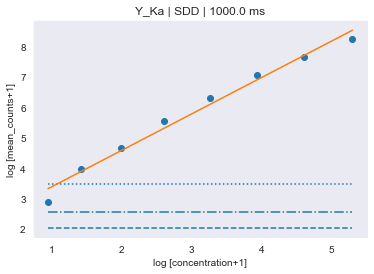

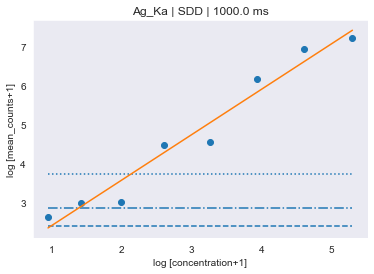

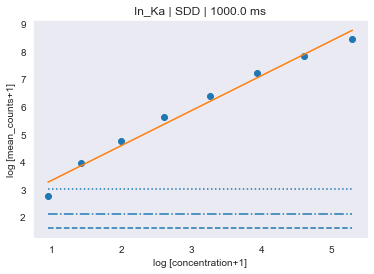

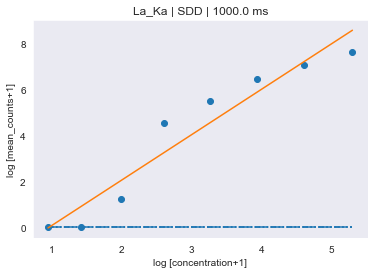

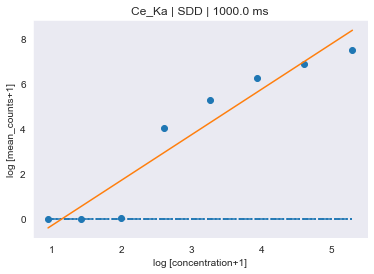

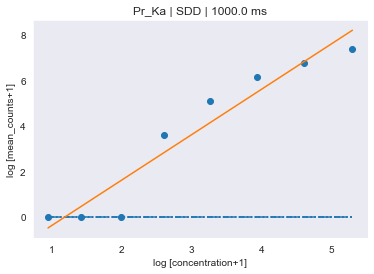

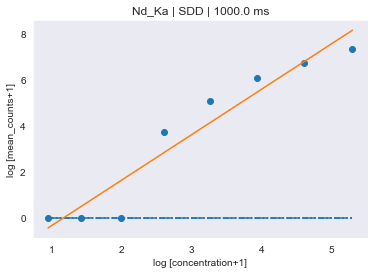

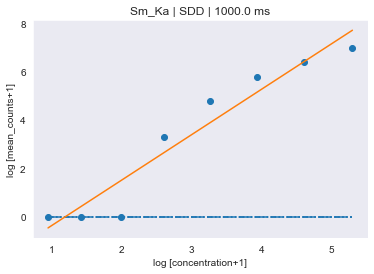

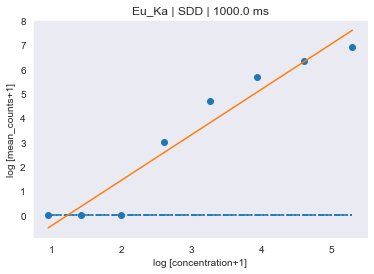

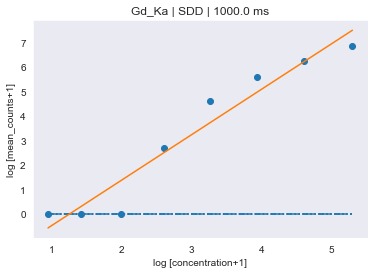

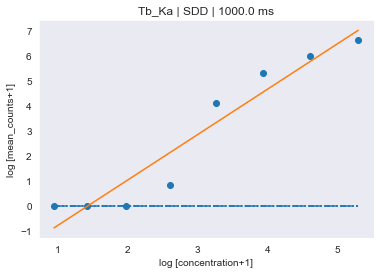

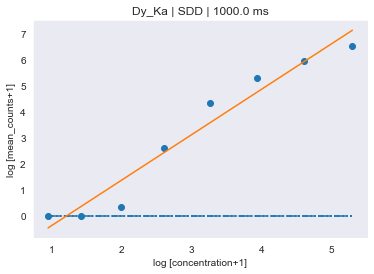

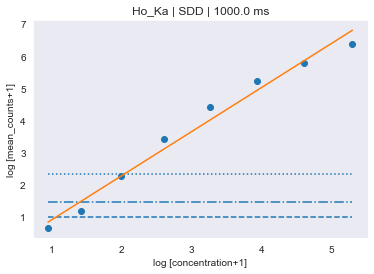

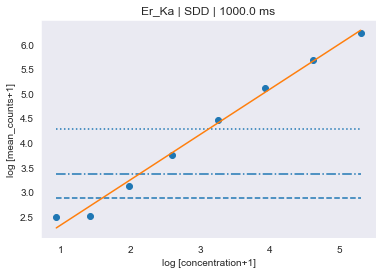

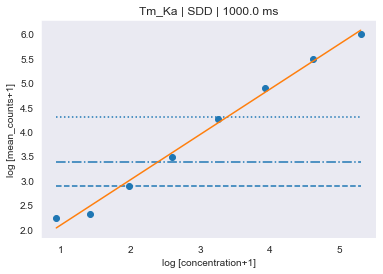

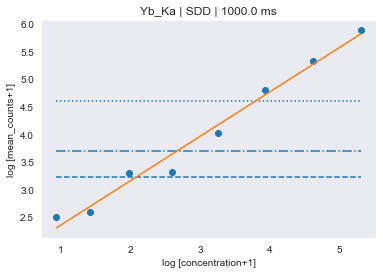

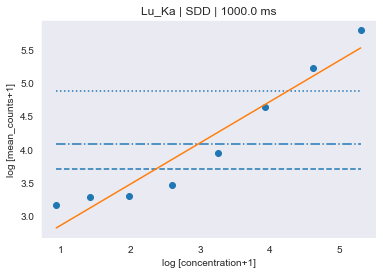

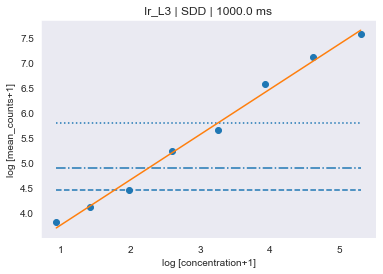

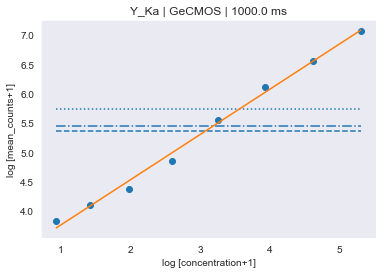

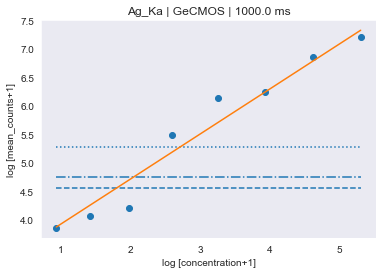

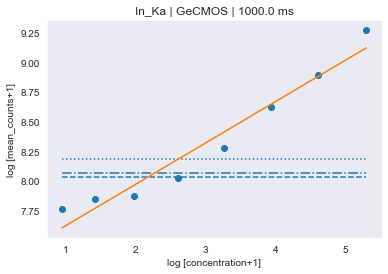

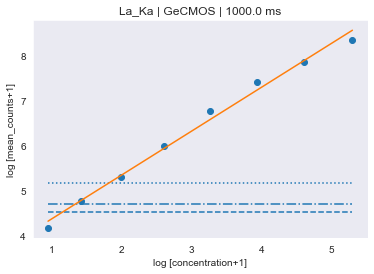

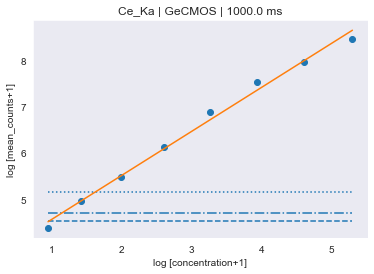

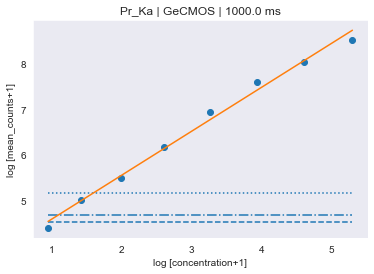

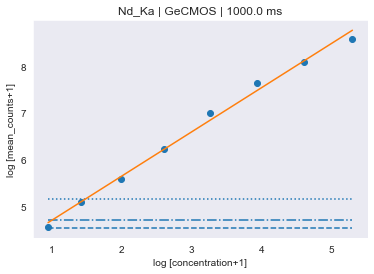

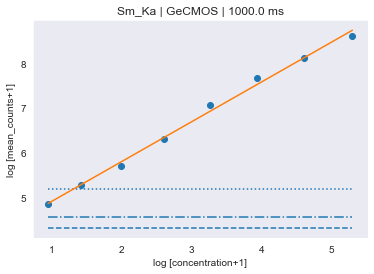

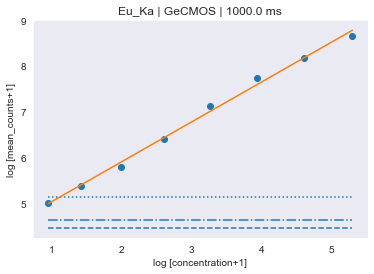

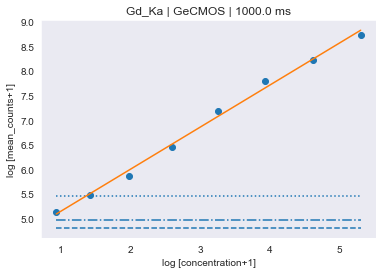

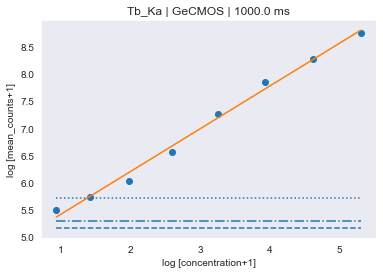

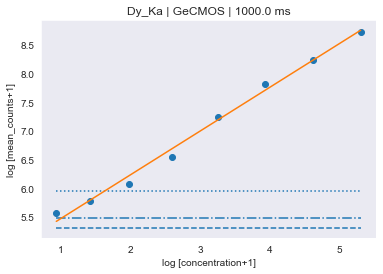

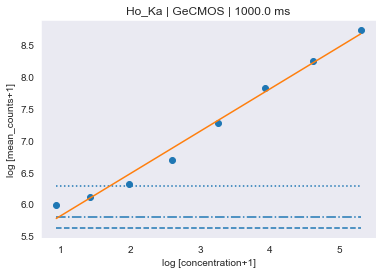

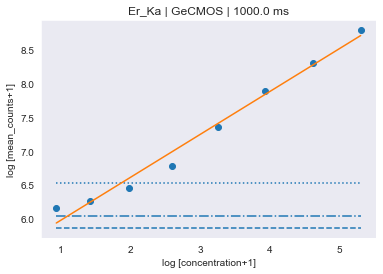

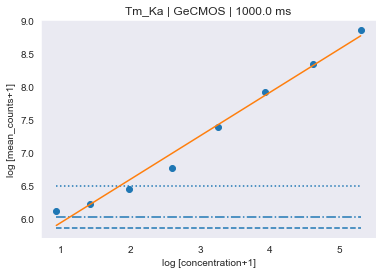

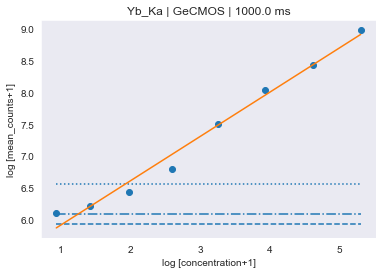

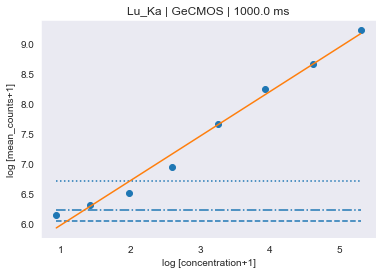

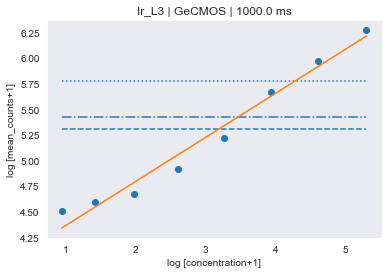

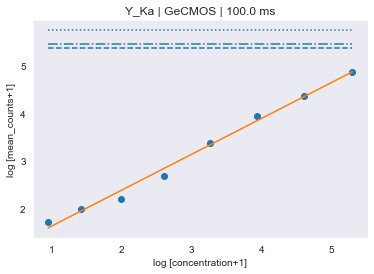

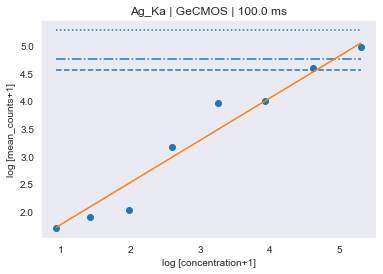

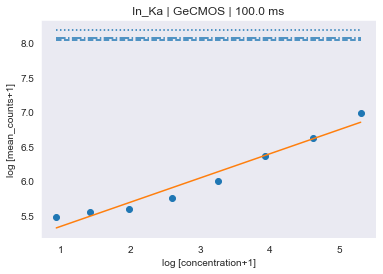

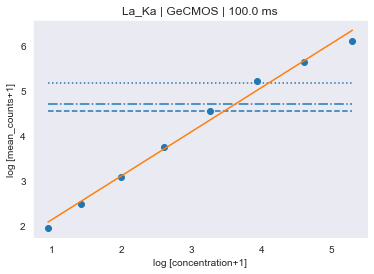

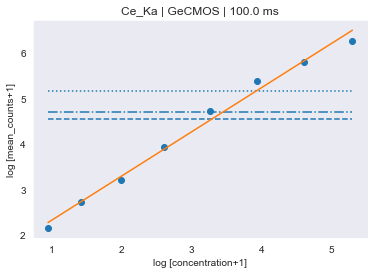

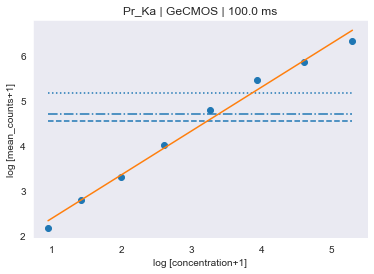

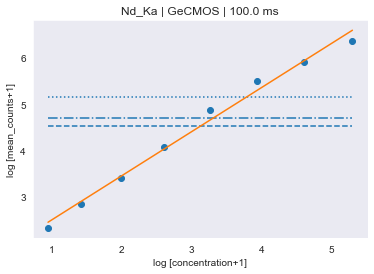

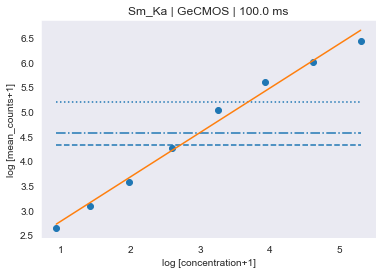

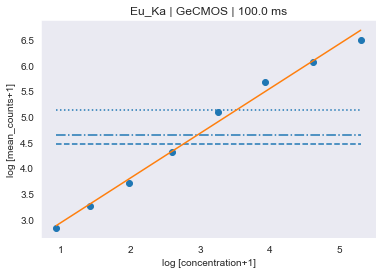

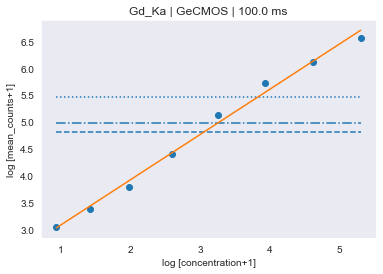

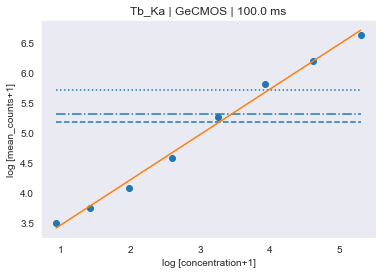

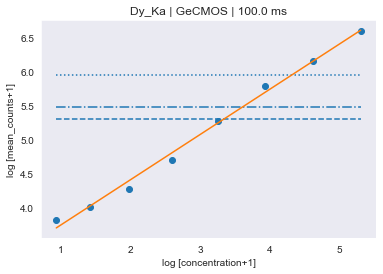

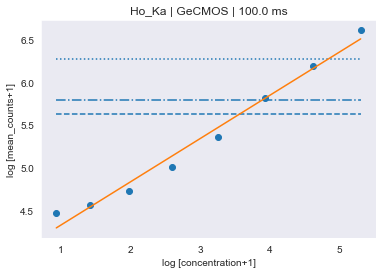

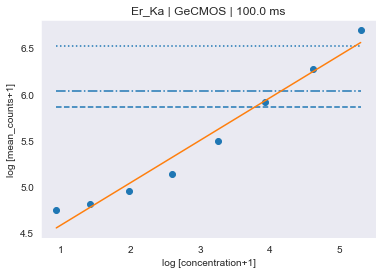

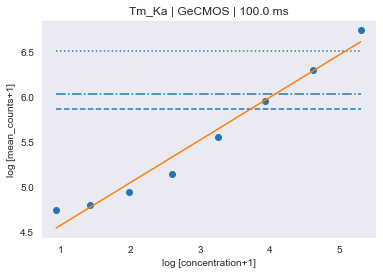

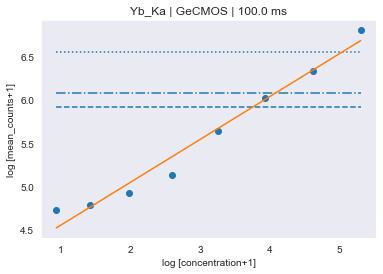

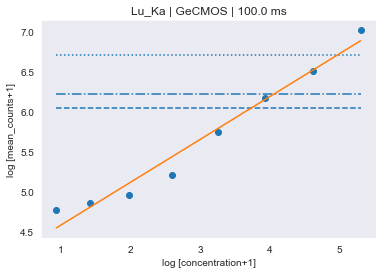

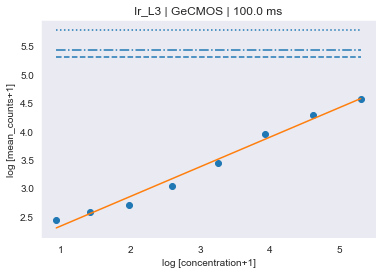

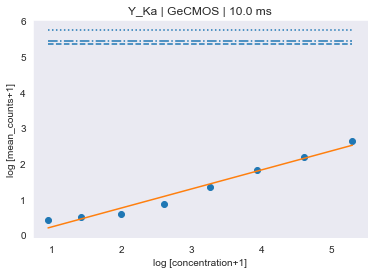

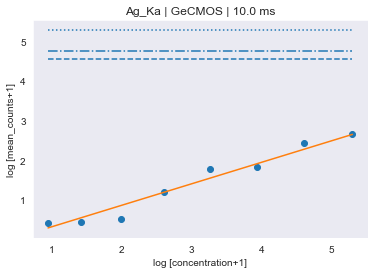

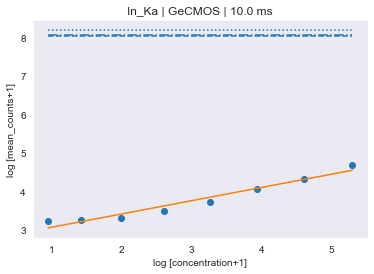

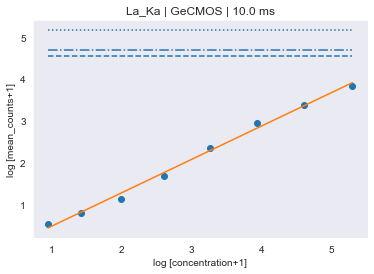

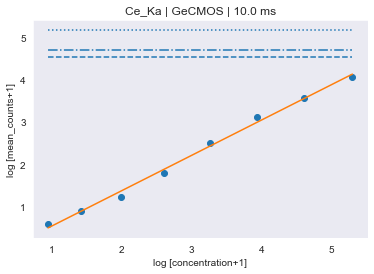

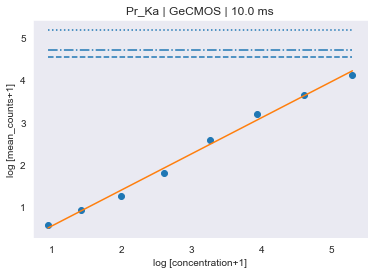

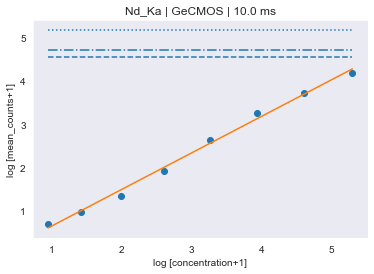

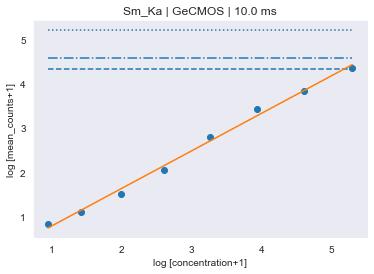

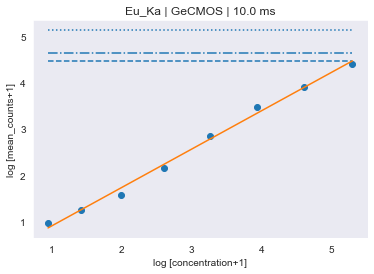

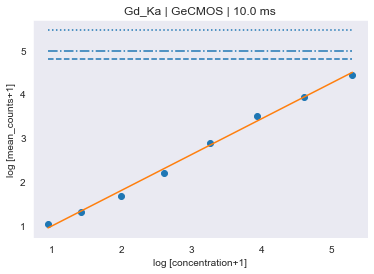

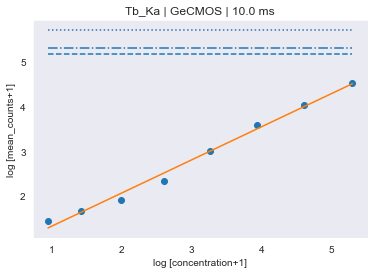

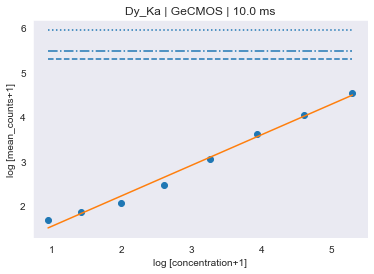

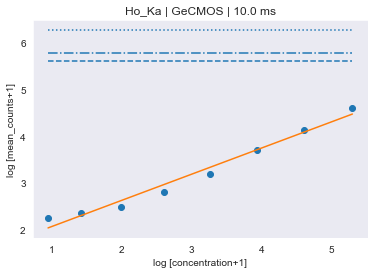

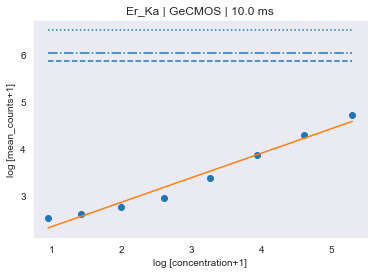

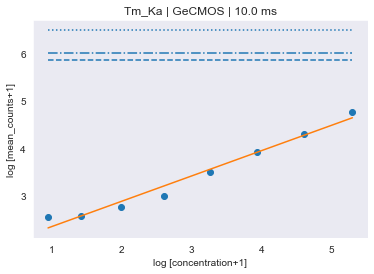

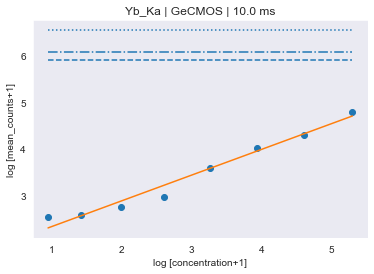

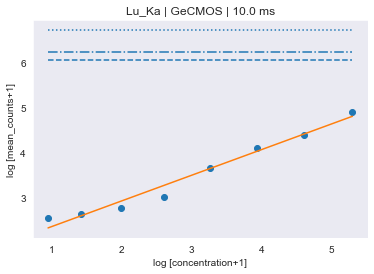

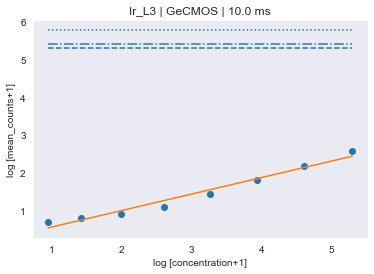

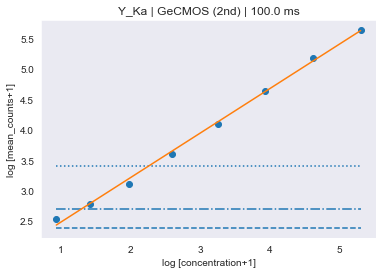

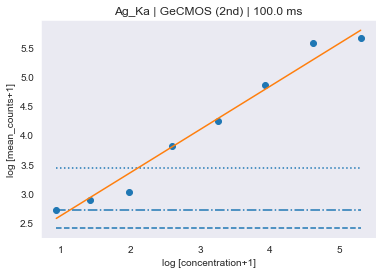

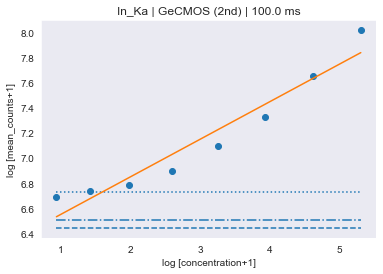

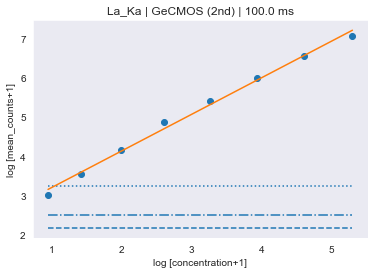

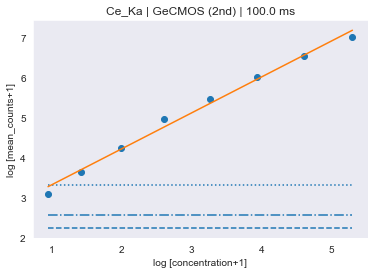

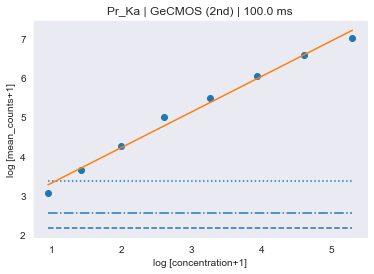

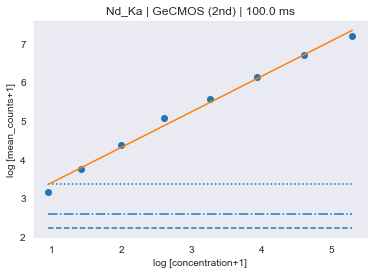

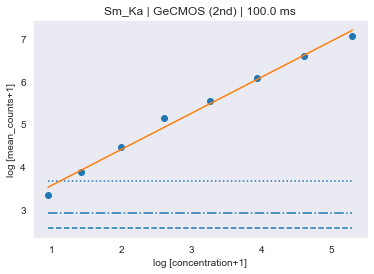

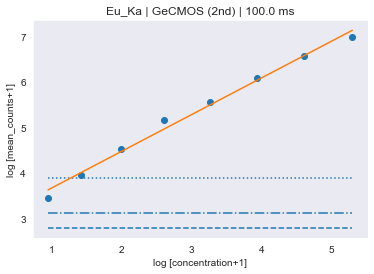

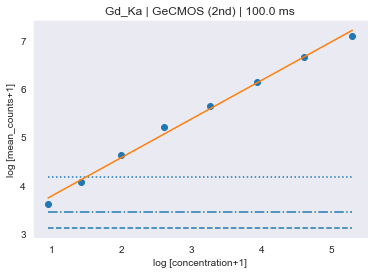

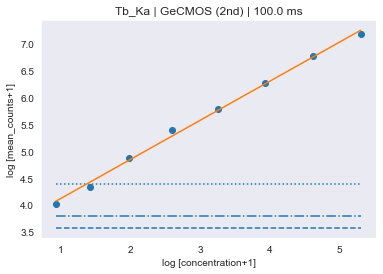

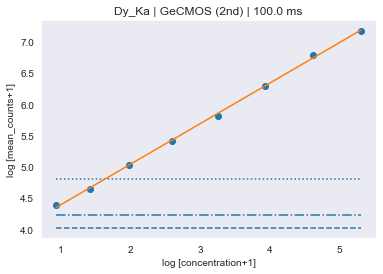

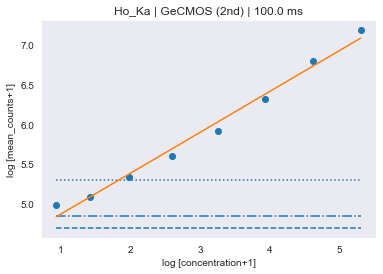

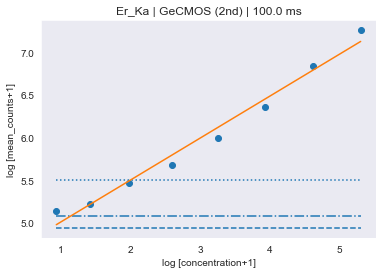

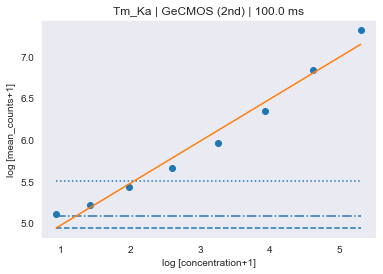

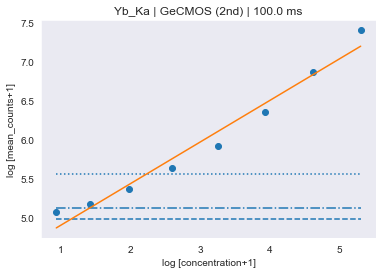

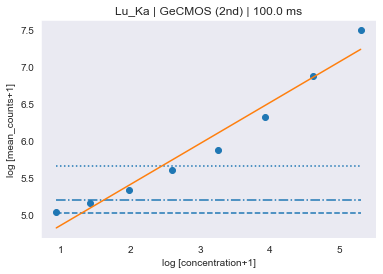

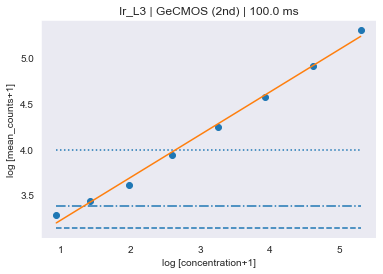

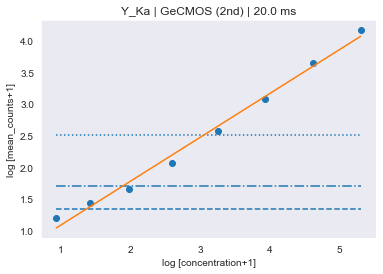

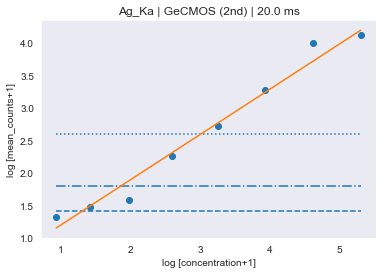

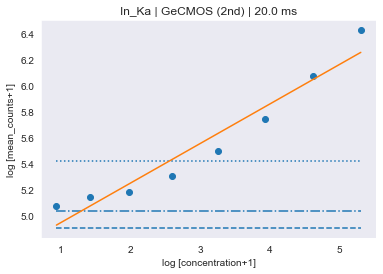

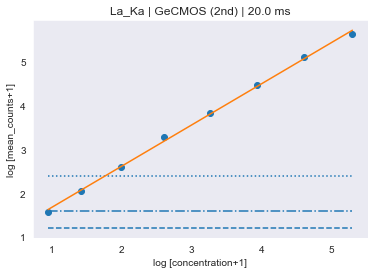

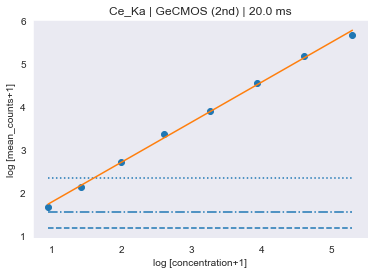

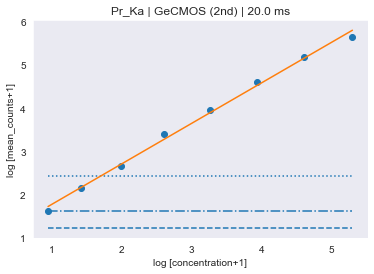

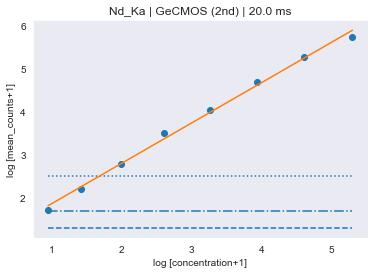

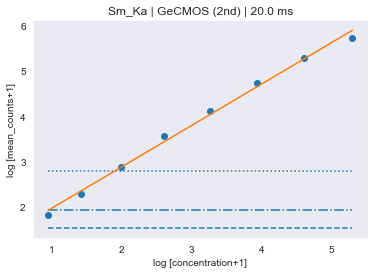

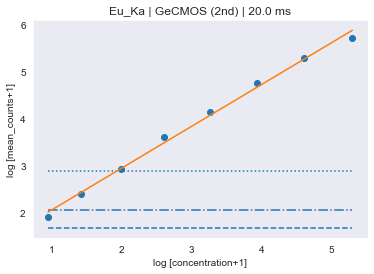

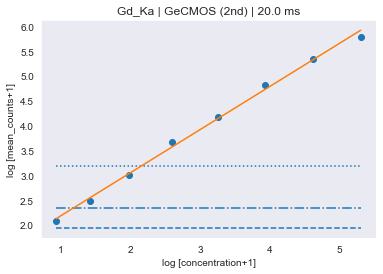

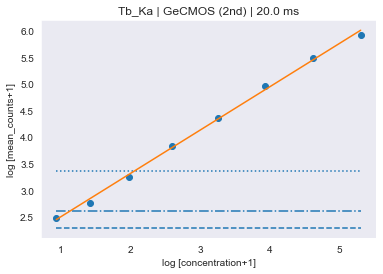

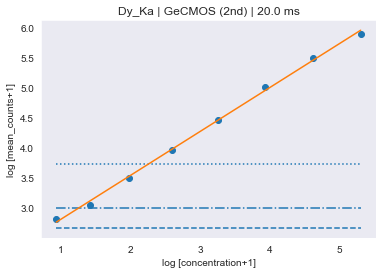

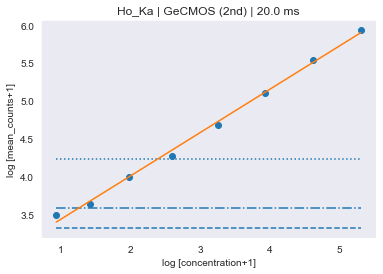

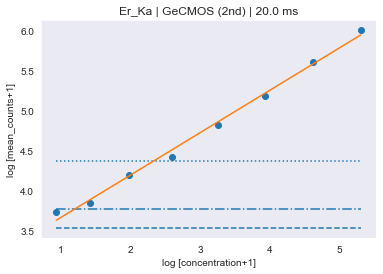

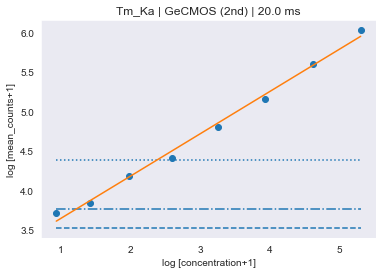

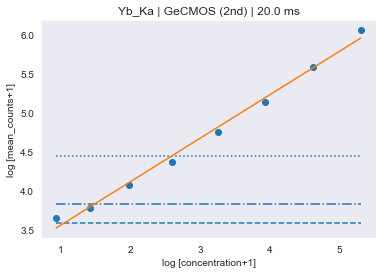

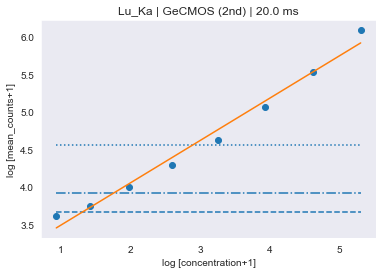

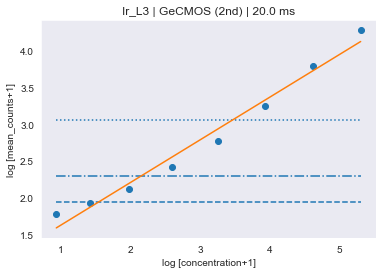

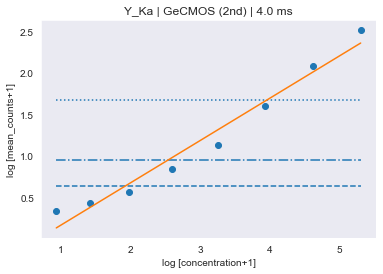

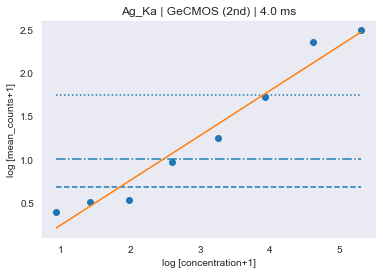

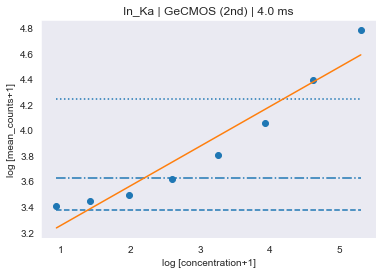

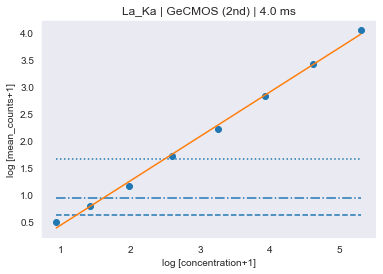

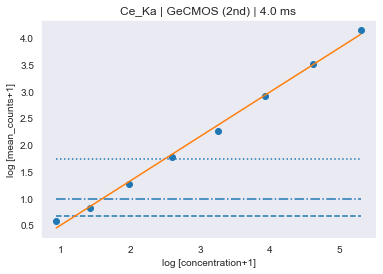

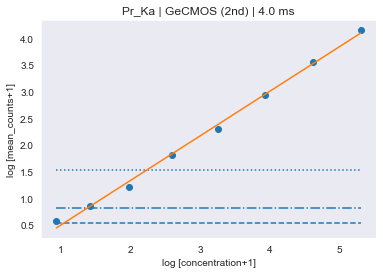

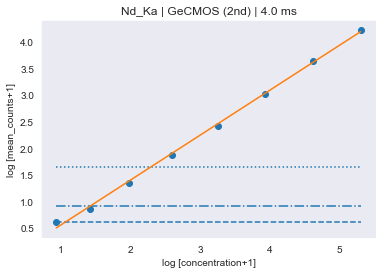

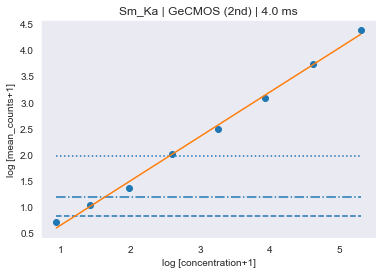

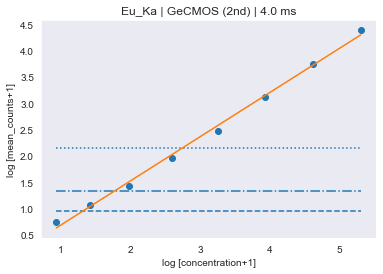

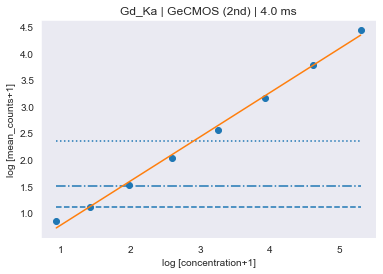

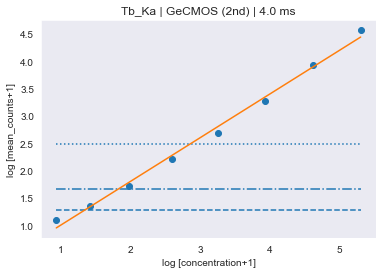

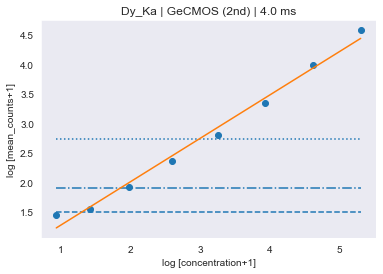

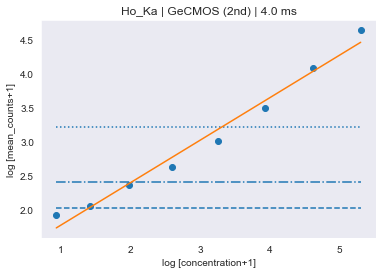

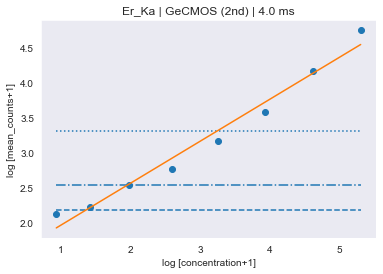

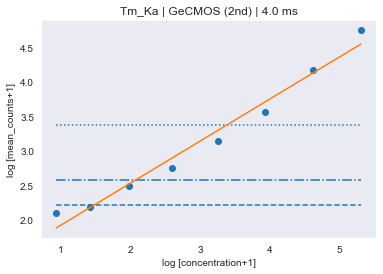

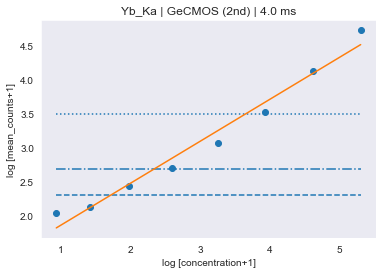

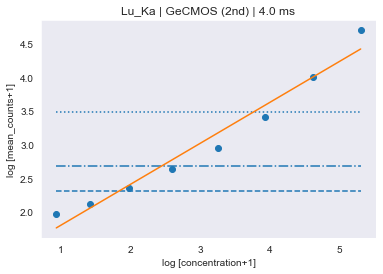

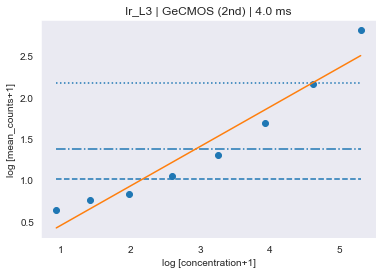

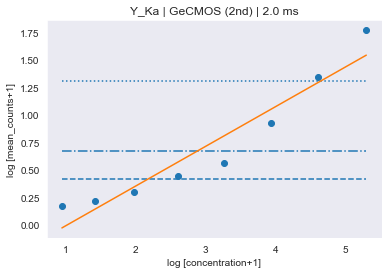

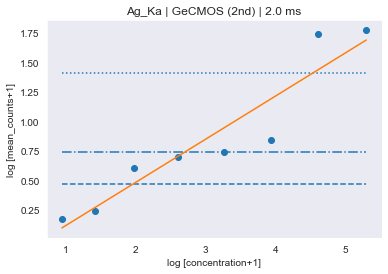

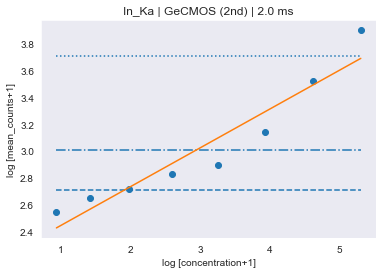

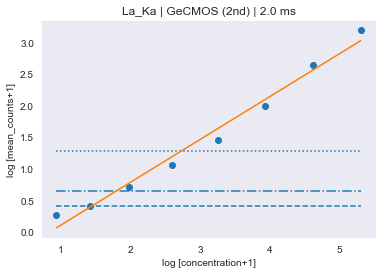

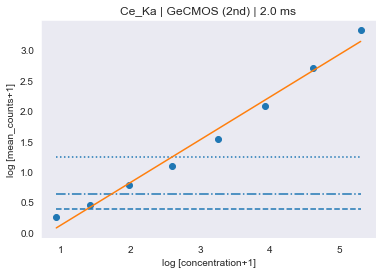

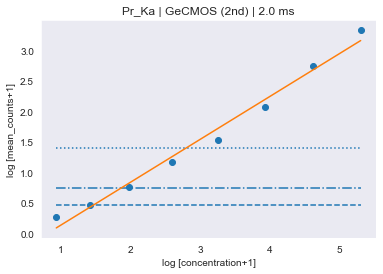

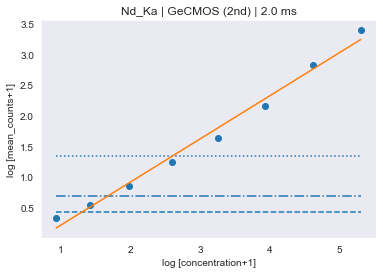

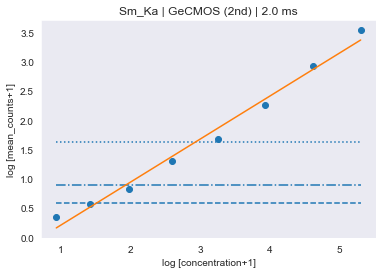

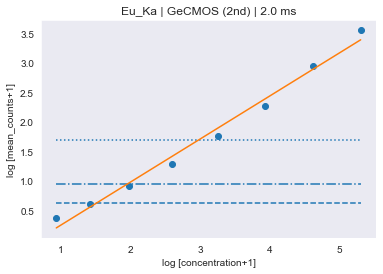

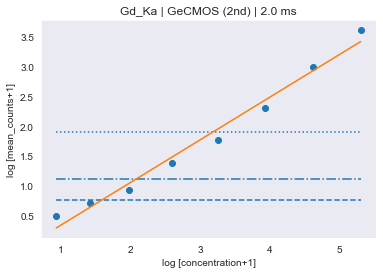

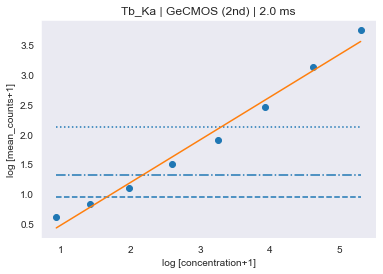

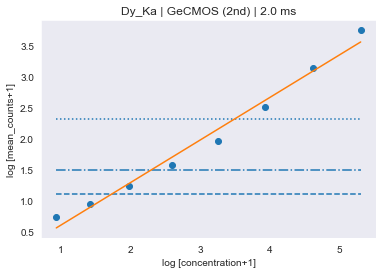

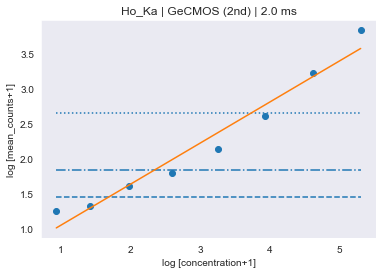

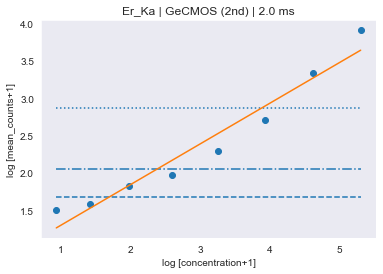

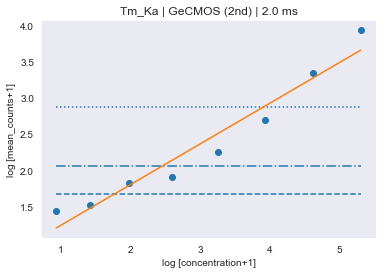

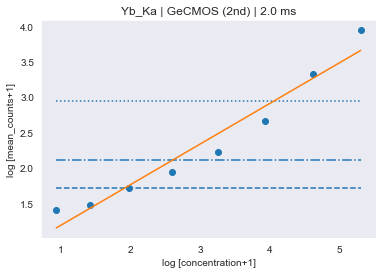

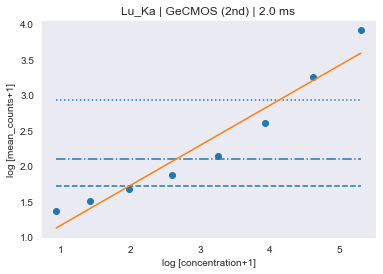

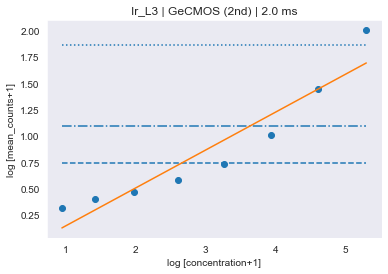

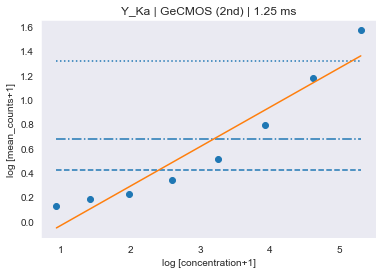

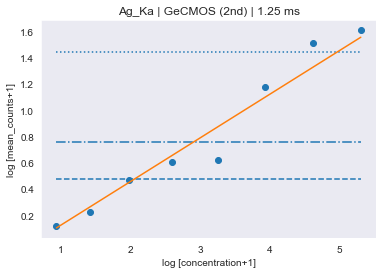

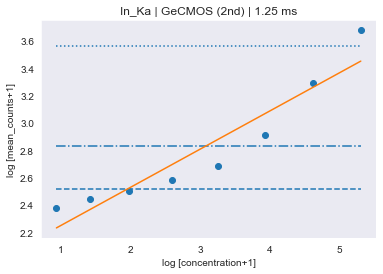

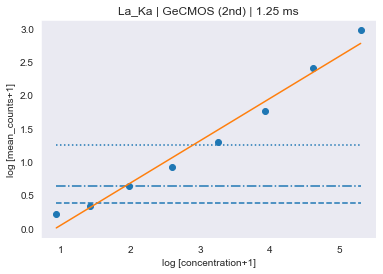

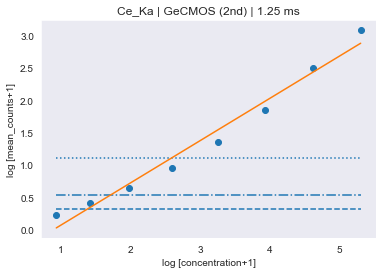

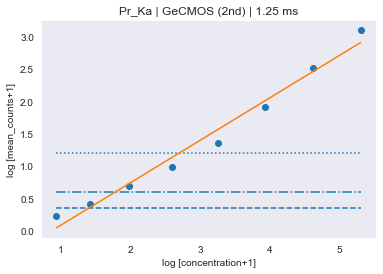

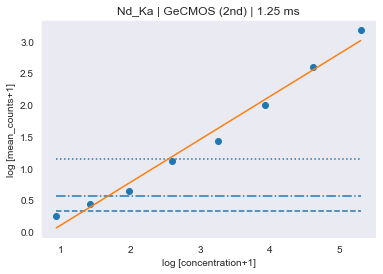

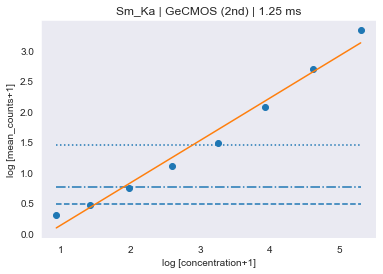

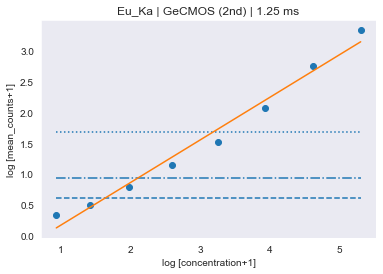

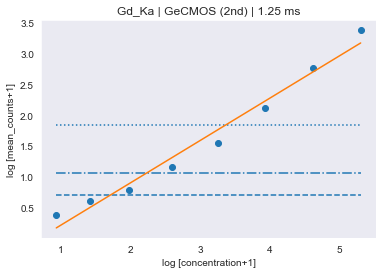

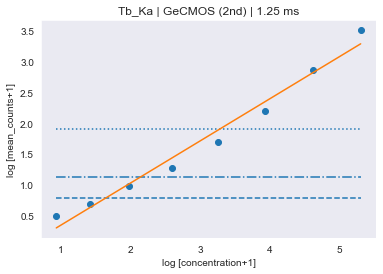

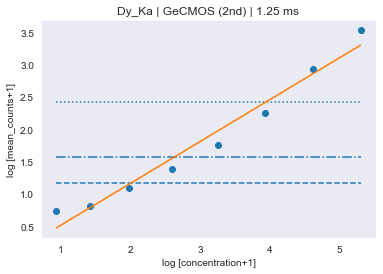

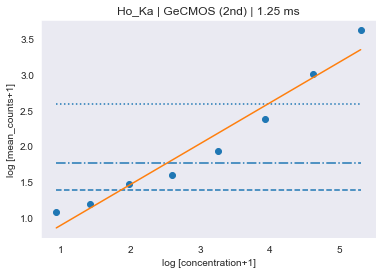

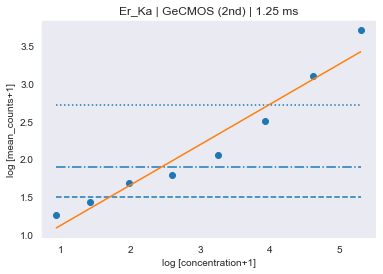

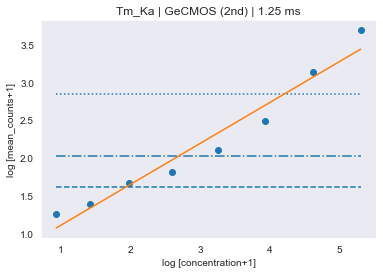

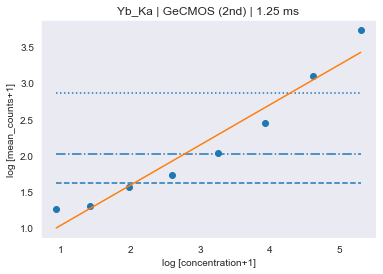

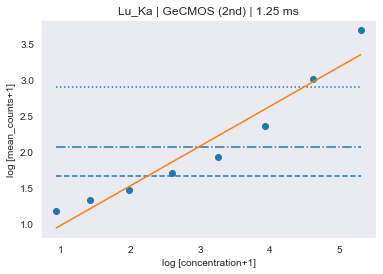

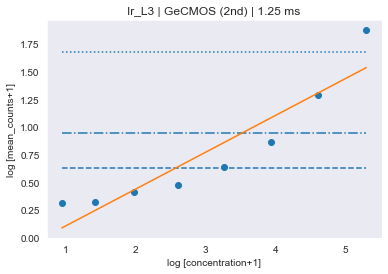

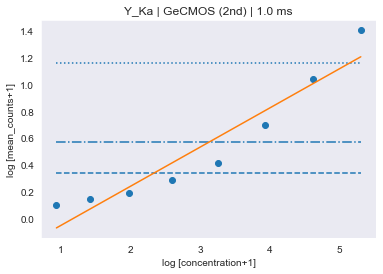

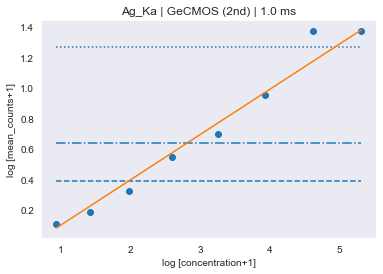

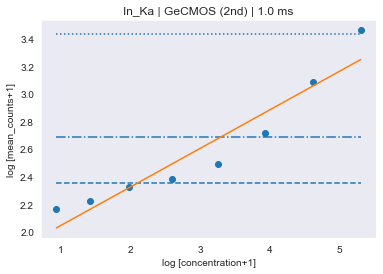

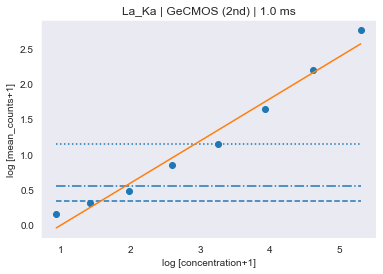

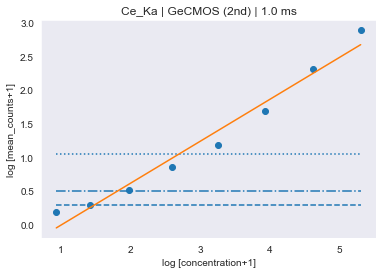

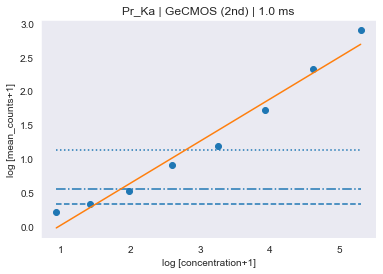

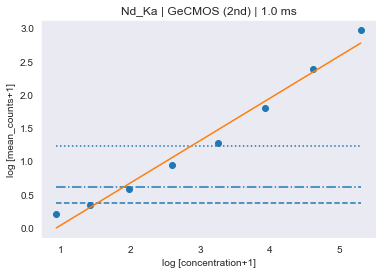

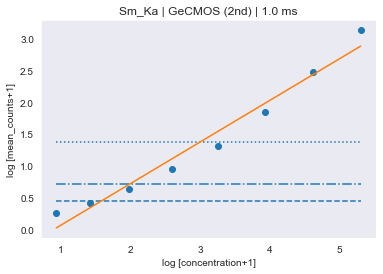

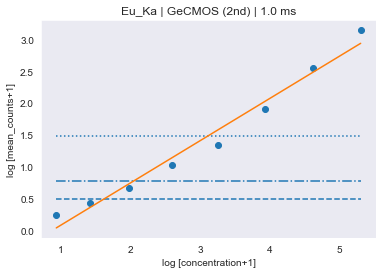

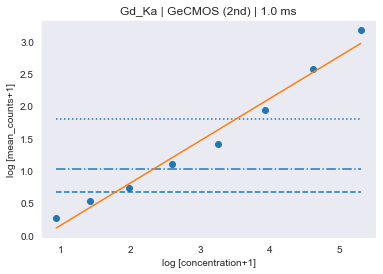

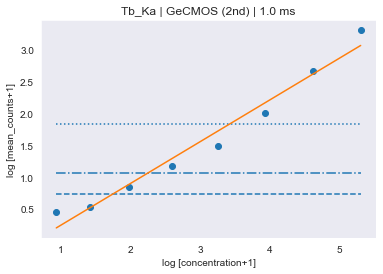

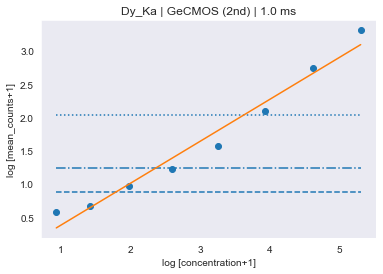

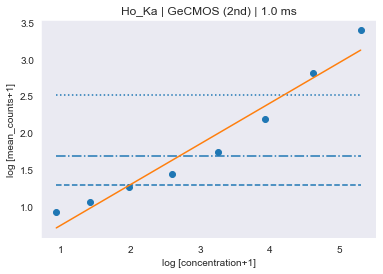

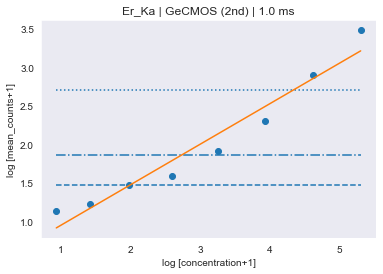

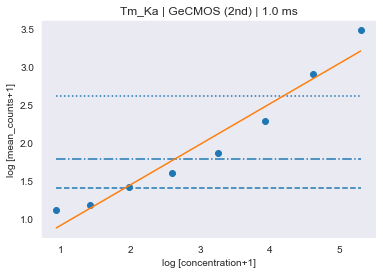

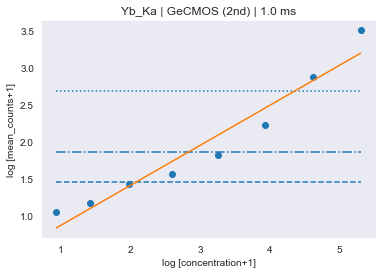

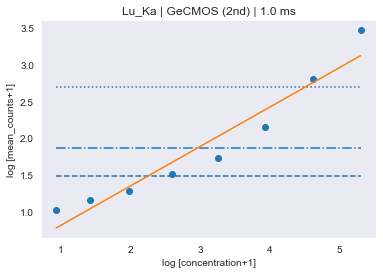

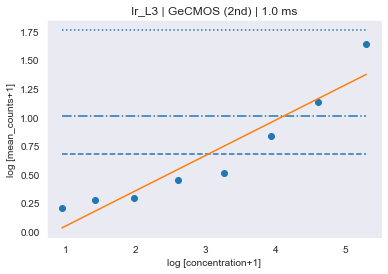

In [19]:
from numpy.polynomial import Polynomial

limits = [
    'Detector', 
    'dwell_ms',
    'element_emission_line', 
    'blank_counts', 
    'blank_std', 
    'lob_intercept', 
    'lod_intercept', 
    'loq_intercept',
    'lob_concentration', 
    'lod_concentration', 
    'loq_concentration', 
]

df_detection_limits = pd.DataFrame(columns=limits)

for detector in df_standard_measurements['detector'].unique():
    df_detector = df_standard_measurements[
        df_standard_measurements['detector'] == detector
    ]
    
    for dwell_ms in df_detector['dwell_ms'].unique():
            df_detector_dwell = df_detector[
                df_detector['dwell_ms'] == dwell_ms
            ]
        
            for emission_line in emission_lines:
                limits_dict = dict.fromkeys(limits)
                limits_dict['Detector'] = detector
                limits_dict['dwell_ms'] = dwell_ms

                df_emission_line = df_detector_dwell[
                    (df_detector_dwell['element_emission_line'] == emission_line)
                    & (df_detector_dwell['log_concentration'] != 0)
                    #& (df_detector_dwell['log_mean_counts'] > 0)
                ]

                df_emission_line_blank = df_detector_dwell[
                        (df_detector_dwell['element_emission_line'] == emission_line)
                        & (df_detector_dwell['concentration_ppm'] == 0)
                    ]

                # This condition sets the La_Ka, Ce_Ka and Pr_Ka blank to that of Nd_Ka blank to Ce for GeCMOS detector
                if (detector == 'GeCMOS') & (emission_line in ['La_Ka', 'Ce_Ka', 'Nd_Ka']):
                    df_emission_line_blank = df_detector_dwell[
                        (df_detector_dwell['element_emission_line'] == 'Pr_Ka')
                        & (df_detector_dwell['concentration_ppm'] == 0)
                    ]

                limits_dict['element_emission_line'] = emission_line
                limits_dict['blank_counts'] = df_emission_line_blank['img_mean'].iloc[0]
                limits_dict['blank_std'] = df_emission_line_blank['img_std'].iloc[0]

                x_data = df_emission_line['log_concentration']
                y_data = df_emission_line['log_mean_counts']

                x1 = np.sort(x_data, 0)
                y1 = np.sort(y_data, 0)
                plt.plot(x1, y1, 'o')

                p = Polynomial.fit(x_data, y_data, deg=1)        
                x2 = np.sort(x_data, 0)
                y2 = np.sort(p(x_data), 0)
                plt.plot(x2, y2)

                lob = np.log(limits_dict['blank_counts'] + 1.645*limits_dict['blank_std'] + 1)
                lod = np.log(limits_dict['blank_counts'] + 3.33*limits_dict['blank_std'] + 1)
                loq = np.log(limits_dict['blank_counts'] + 10*limits_dict['blank_std'] + 1)

                plt.hlines(lob, xmin = min(x_data), xmax = max(x_data), linestyles = 'dashed')
                plt.hlines(lod, xmin = min(x_data), xmax = max(x_data), linestyles = 'dashdot')
                plt.hlines(loq, xmin = min(x_data), xmax = max(x_data), linestyles = 'dotted')

                # Record concentration where regression line intercepts limit of choice
                limits_dict['lob_intercept'] = (p-lob).roots()[-1]
                limits_dict['lod_intercept'] = (p-lod).roots()[-1]
                limits_dict['loq_intercept'] = (p-loq).roots()[-1]

                # Convert to conecntrations
                limits_dict['lob_concentration'] = np.exp(limits_dict['lob_intercept'] - 1)
                limits_dict['lod_concentration'] = np.exp(limits_dict['lod_intercept'] - 1)
                limits_dict['loq_concentration'] = np.exp(limits_dict['loq_intercept'] - 1)

                plt.xlabel('log [concentration+1]')
                plt.ylabel('log [mean_counts+1]')
                plt.title(f'{emission_line} | {detector} | {dwell_ms} ms')
                plt.show()

                df_detection_limits = df_detection_limits.append(limits_dict, ignore_index=True)



Add in the key columns for plotting out detection limits

In [20]:
df_detection_limits['element'] = (
    df_detection_limits.element_emission_line.str.split(
        '_', expand=True).iloc[:,0]
)
df_detection_limits['emission_line'] = (
    df_detection_limits.element_emission_line.str.split(
        '_', expand=True).iloc[:,-1]
)

df_detection_limits = pd.merge(
    df_periodic_table[['AtomicNumber', 'Symbol']], 
    df_detection_limits, 
    how='right', 
    left_on='Symbol', 
    right_on='element'
)

df_detection_limits['Raster rate (Hz)'] = 1000/df_detection_limits['dwell_ms']


In [21]:
df_detection_limits.columns

Index(['AtomicNumber', 'Symbol', 'Detector', 'dwell_ms',
       'element_emission_line', 'blank_counts', 'blank_std', 'lob_intercept',
       'lod_intercept', 'loq_intercept', 'lob_concentration',
       'lod_concentration', 'loq_concentration', 'element', 'emission_line',
       'Raster rate (Hz)'],
      dtype='object')

Plot out detection limits

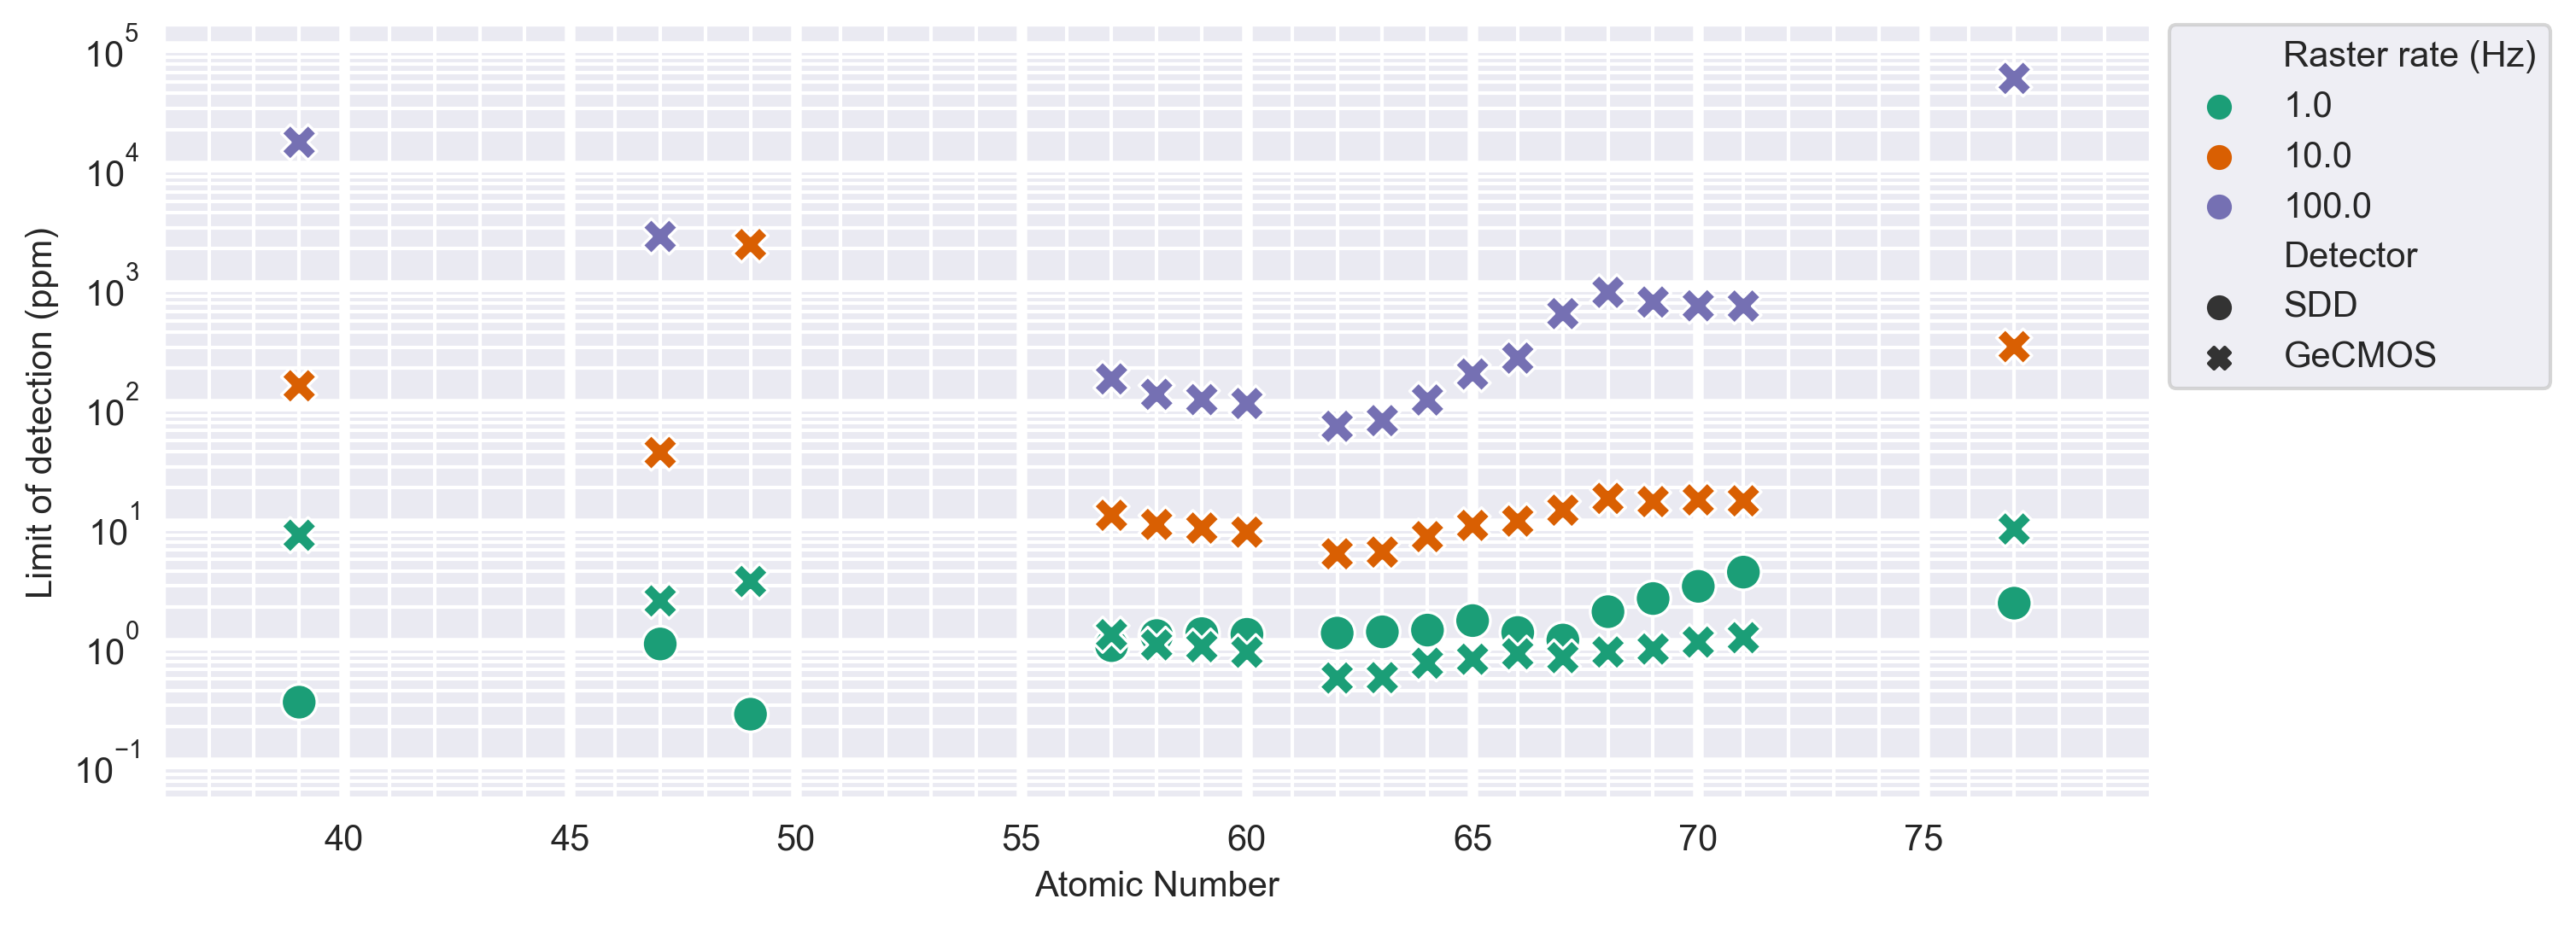

In [22]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.scatterplot(
    #data=df_detection_limits,
    data=df_detection_limits[df_detection_limits['Detector'].isin(['SDD', 'GeCMOS'])],
    x='AtomicNumber',
    y='lob_concentration',
    hue='Raster rate (Hz)',
    palette='Dark2',
    style='Detector',  
    ax=ax,
    s=100
)

#Set y to log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
ax.set(yscale="log")
ax.set_ylim([0.05,150000])
#ax.yaxis.set_major_formatter(ScalarFormatter())

ax.set_xticks(list(range(35, 80, 5)))
ax.set_xticks(list(range(35, 80, 1)), minor=True)
ax.set_xlim([36,80])

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Atomic Number')
plt.ylabel('Limit of detection (ppm)')

plt.show()


In [23]:
df_detection_limits['Detector'].unique()

array(['SDD', 'GeCMOS', 'GeCMOS (2nd)'], dtype=object)

In [24]:
df_detection_limits['Raster rate (Hz)'].unique()

array([   1.,   10.,  100.,   50.,  250.,  500.,  800., 1000.])

In [25]:
df_plot = df_detection_limits[
        (df_detection_limits['Detector'].isin(['SDD', 'GeCMOS (2nd)'])) &
        (df_detection_limits['Raster rate (Hz)'].isin([1, 10, 50, 250, 1000]))
].copy()
df_plot['Detector'] = df_plot['Detector'].replace('GeCMOS (2nd)', 'GeCMOS')

C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\xrf\4_xrf_detection_limits\Fig1d_LimitOfDetection.svg


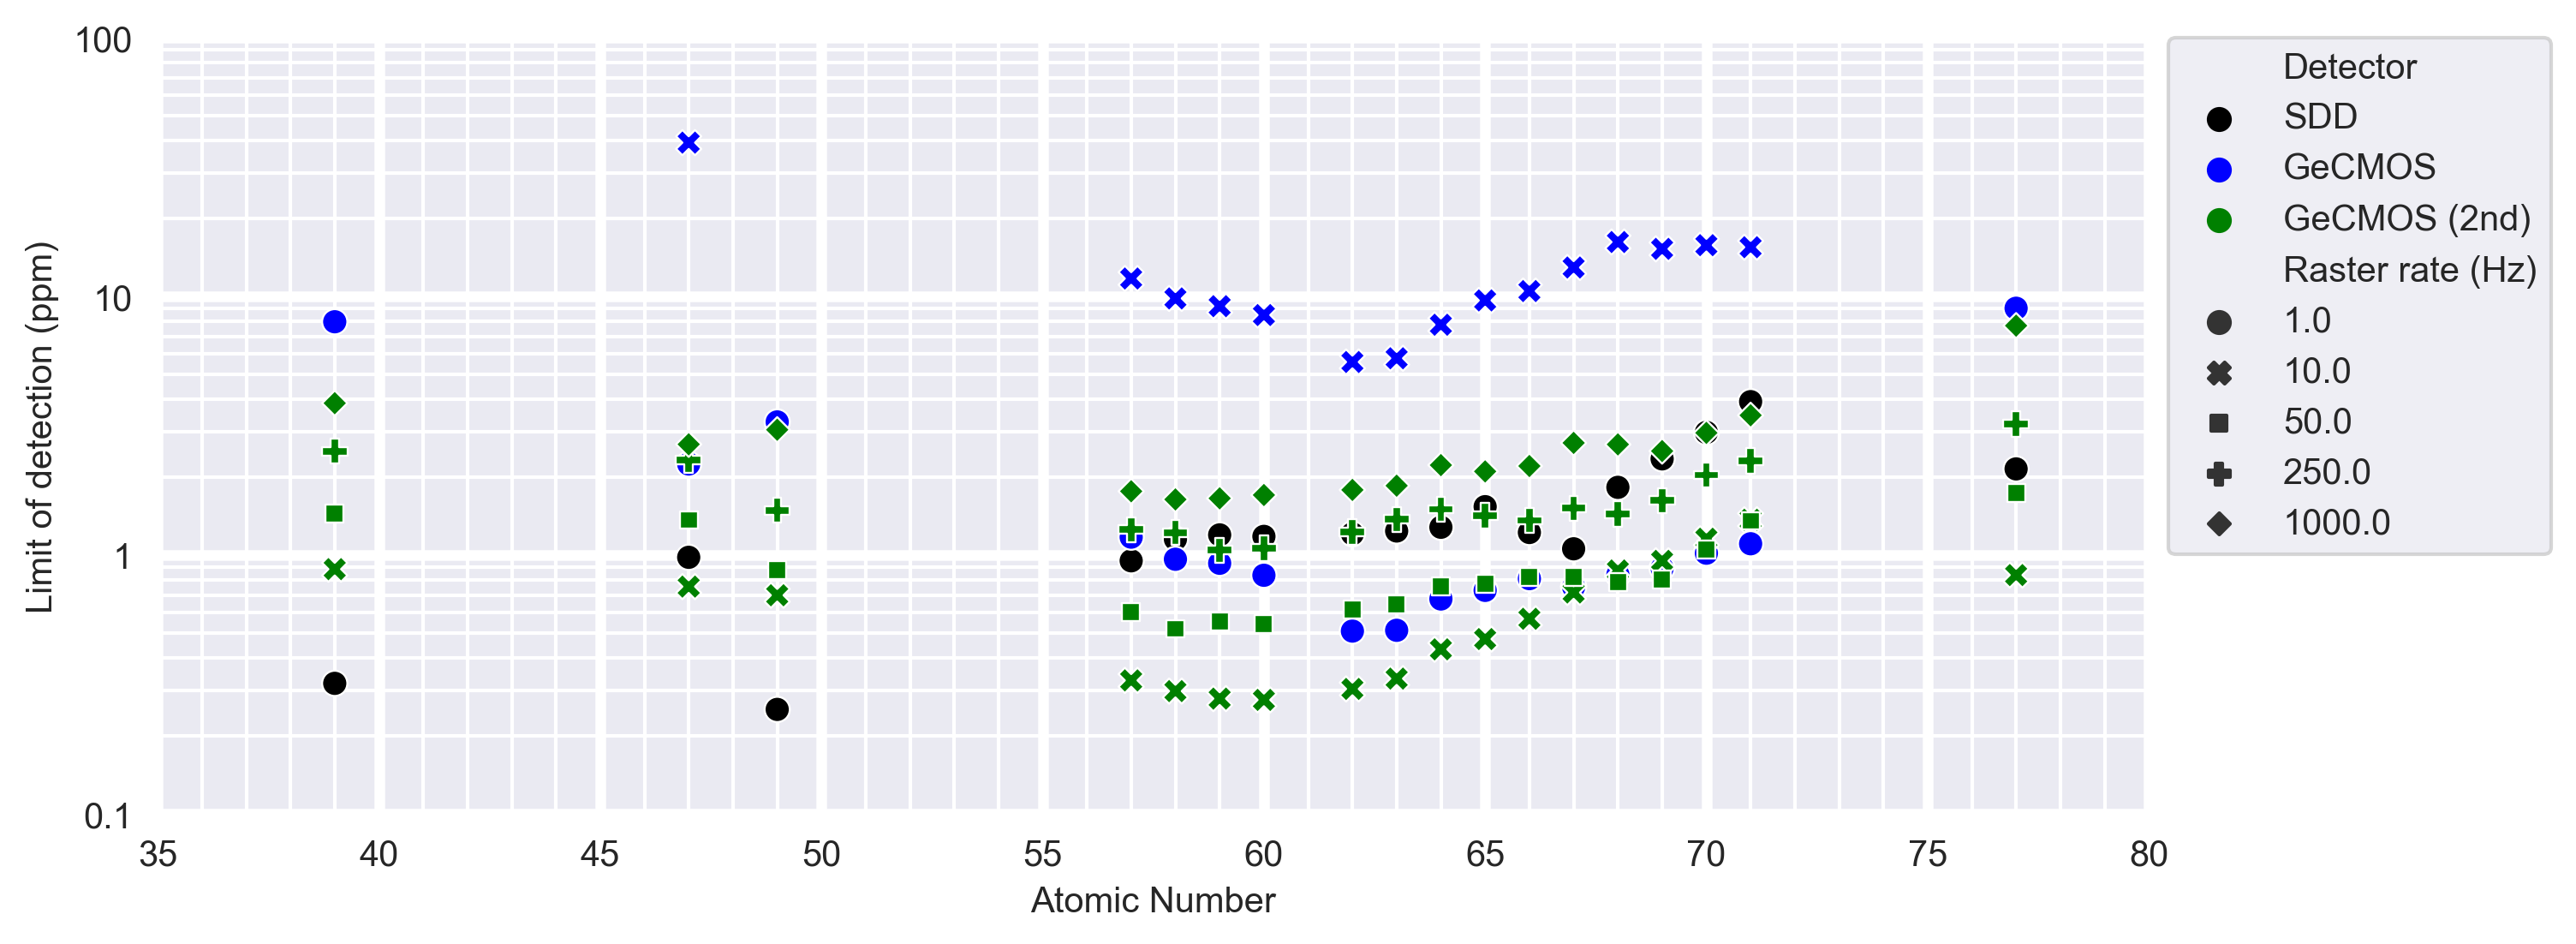

In [26]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.scatterplot(
    #data=df_detection_limits,
    data=df_detection_limits[(df_detection_limits['Raster rate (Hz)'].isin([1, 10, 50, 250, 1000]))],
    x='AtomicNumber',
    y='lob_concentration',

    #palette = sns.color_palette("dark:salmon_r", as_cmap=True),
    #style='Detector',  
    #hue='Raster rate (Hz)',

    palette=['black', 'blue', 'green'],
    style='Raster rate (Hz)',  
    hue='Detector',

    ax=ax,
    s=50
)

#Set y to log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

ax.set(yscale="log")
ax.set_ylim([0.1,100])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax.set_xticks(list(range(35, 85, 5)))
ax.set_xticks(list(range(35, 80, 1)), minor=True)
ax.set_xlim([35,80])

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Atomic Number')
plt.ylabel('Limit of detection (ppm)')

savename = out_dir / 'Fig1d_LimitOfDetection.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')

plt.show()

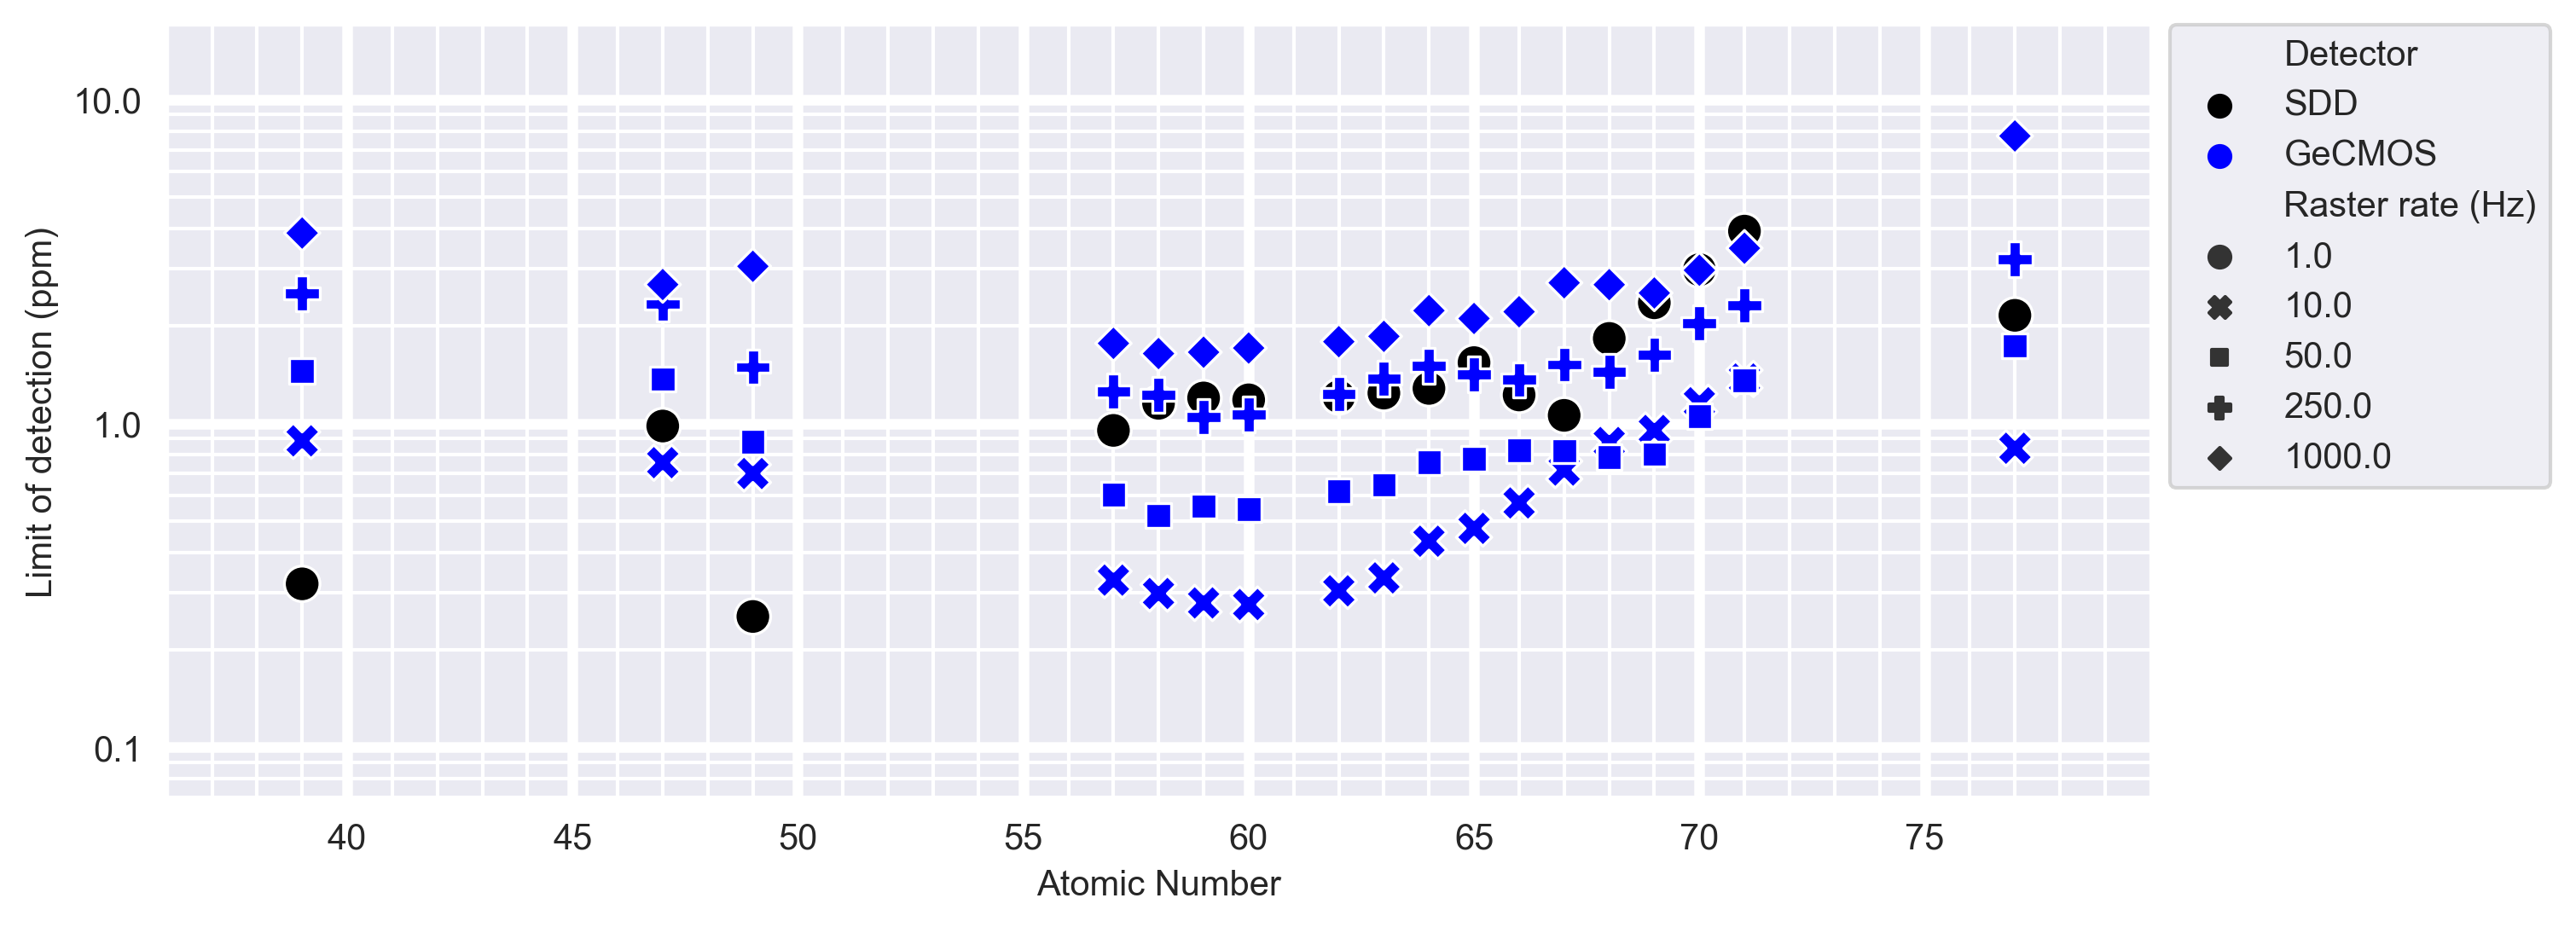

In [27]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.scatterplot(
    #data=df_detection_limits,
    data=df_plot[(df_plot['Raster rate (Hz)'].isin([1, 10, 50, 250, 1000]))],
    x='AtomicNumber',
    y='lob_concentration',

    #palette = sns.color_palette("dark:salmon_r", as_cmap=True),
    #style='Detector',  
    #hue='Raster rate (Hz)',

    palette=['black', 'blue'],
    style='Raster rate (Hz)',  
    hue='Detector',

    ax=ax,
    s=100
)

#Set y to log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
ax.set(yscale="log")
ax.set_ylim([0.07,17])
ax.yaxis.set_major_formatter(ScalarFormatter())



ax.set_xticks(list(range(35, 80, 5)))
ax.set_xticks(list(range(35, 80, 1)), minor=True)
ax.set_xlim([36,80])

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Atomic Number')
plt.ylabel('Limit of detection (ppm)')

plt.show()

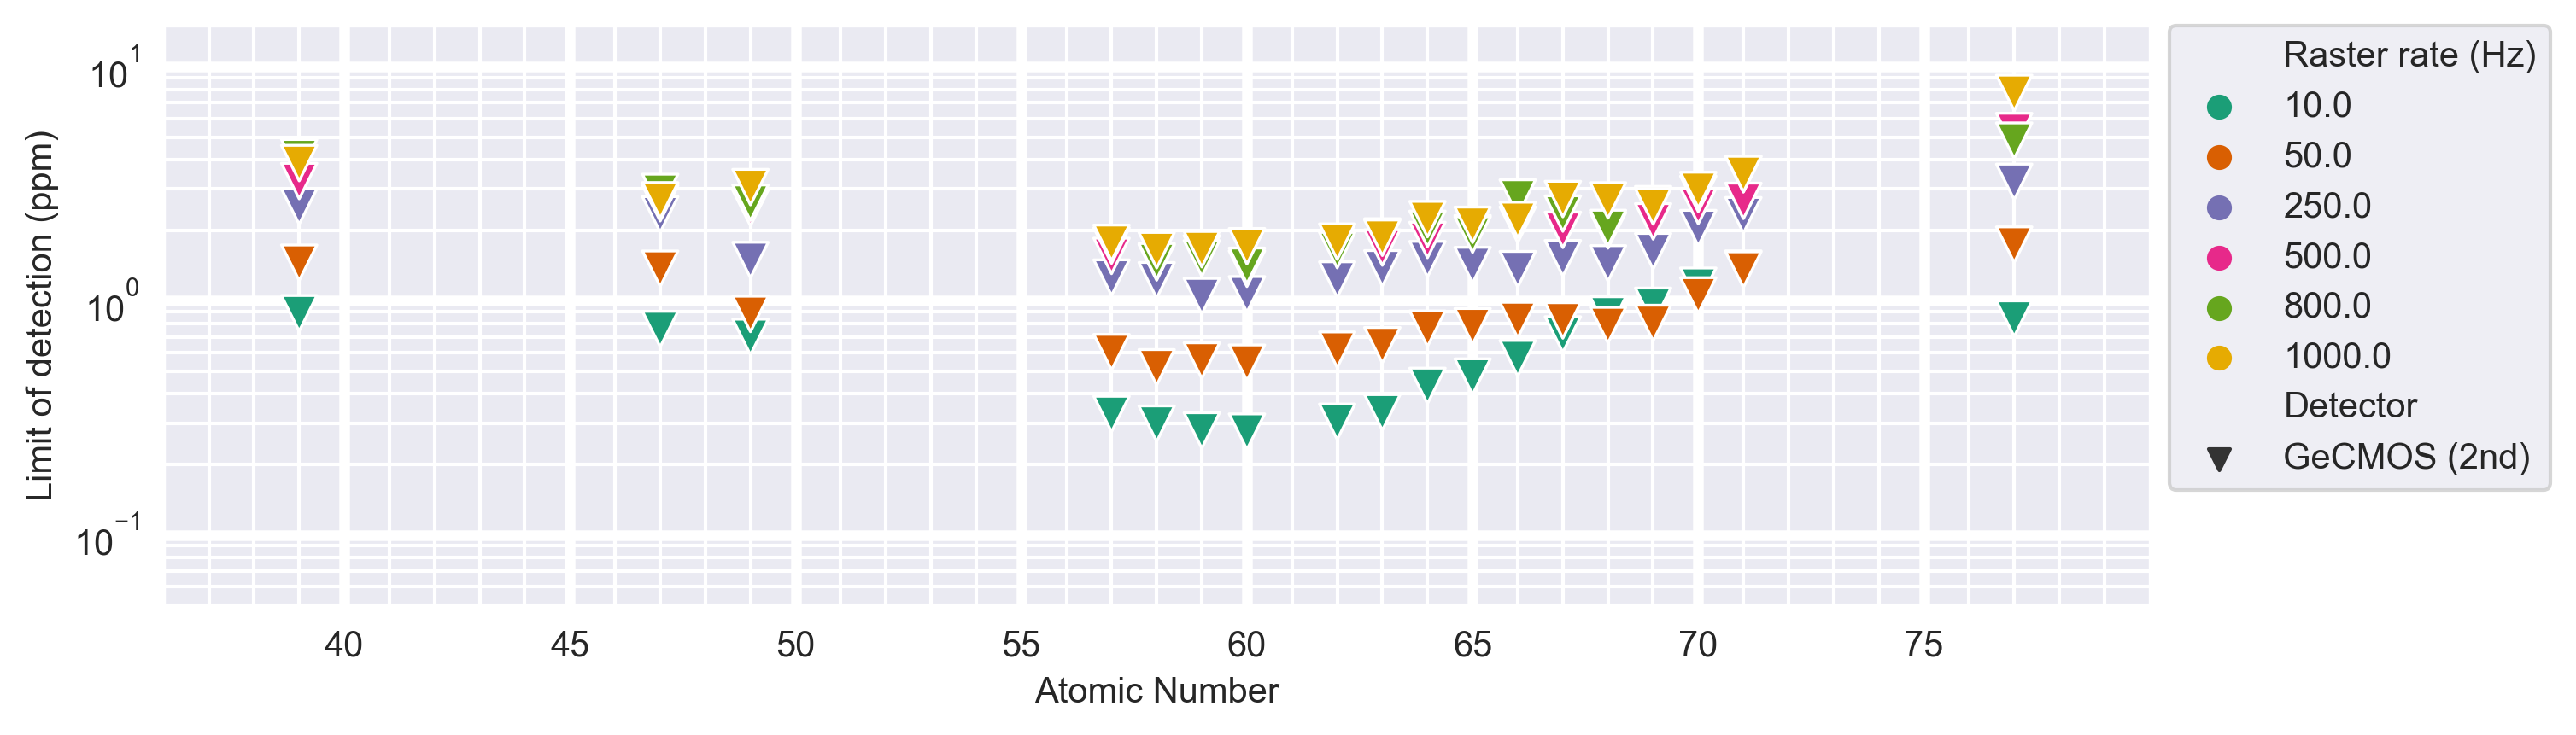

In [28]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,3), dpi=300)
sns.scatterplot(
    #data=df_detection_limits,
    data=df_detection_limits[df_detection_limits['Detector'].isin(['GeCMOS (2nd)'])],
    x='AtomicNumber',
    y='lob_concentration',
    hue='Raster rate (Hz)',
    palette='Dark2',
    style='Detector',
    markers={'GeCMOS (2nd)':'v'},  
    ax=ax,
    s=100
)

#Set y to log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
ax.set(yscale="log")
ax.set_ylim([0.05,15])
#ax.yaxis.set_major_formatter(ScalarFormatter())

ax.set_xticks(list(range(35, 80, 5)))
ax.set_xticks(list(range(35, 80, 1)), minor=True)
ax.set_xlim([36,80])

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Atomic Number')
plt.ylabel('Limit of detection (ppm)')

plt.show()

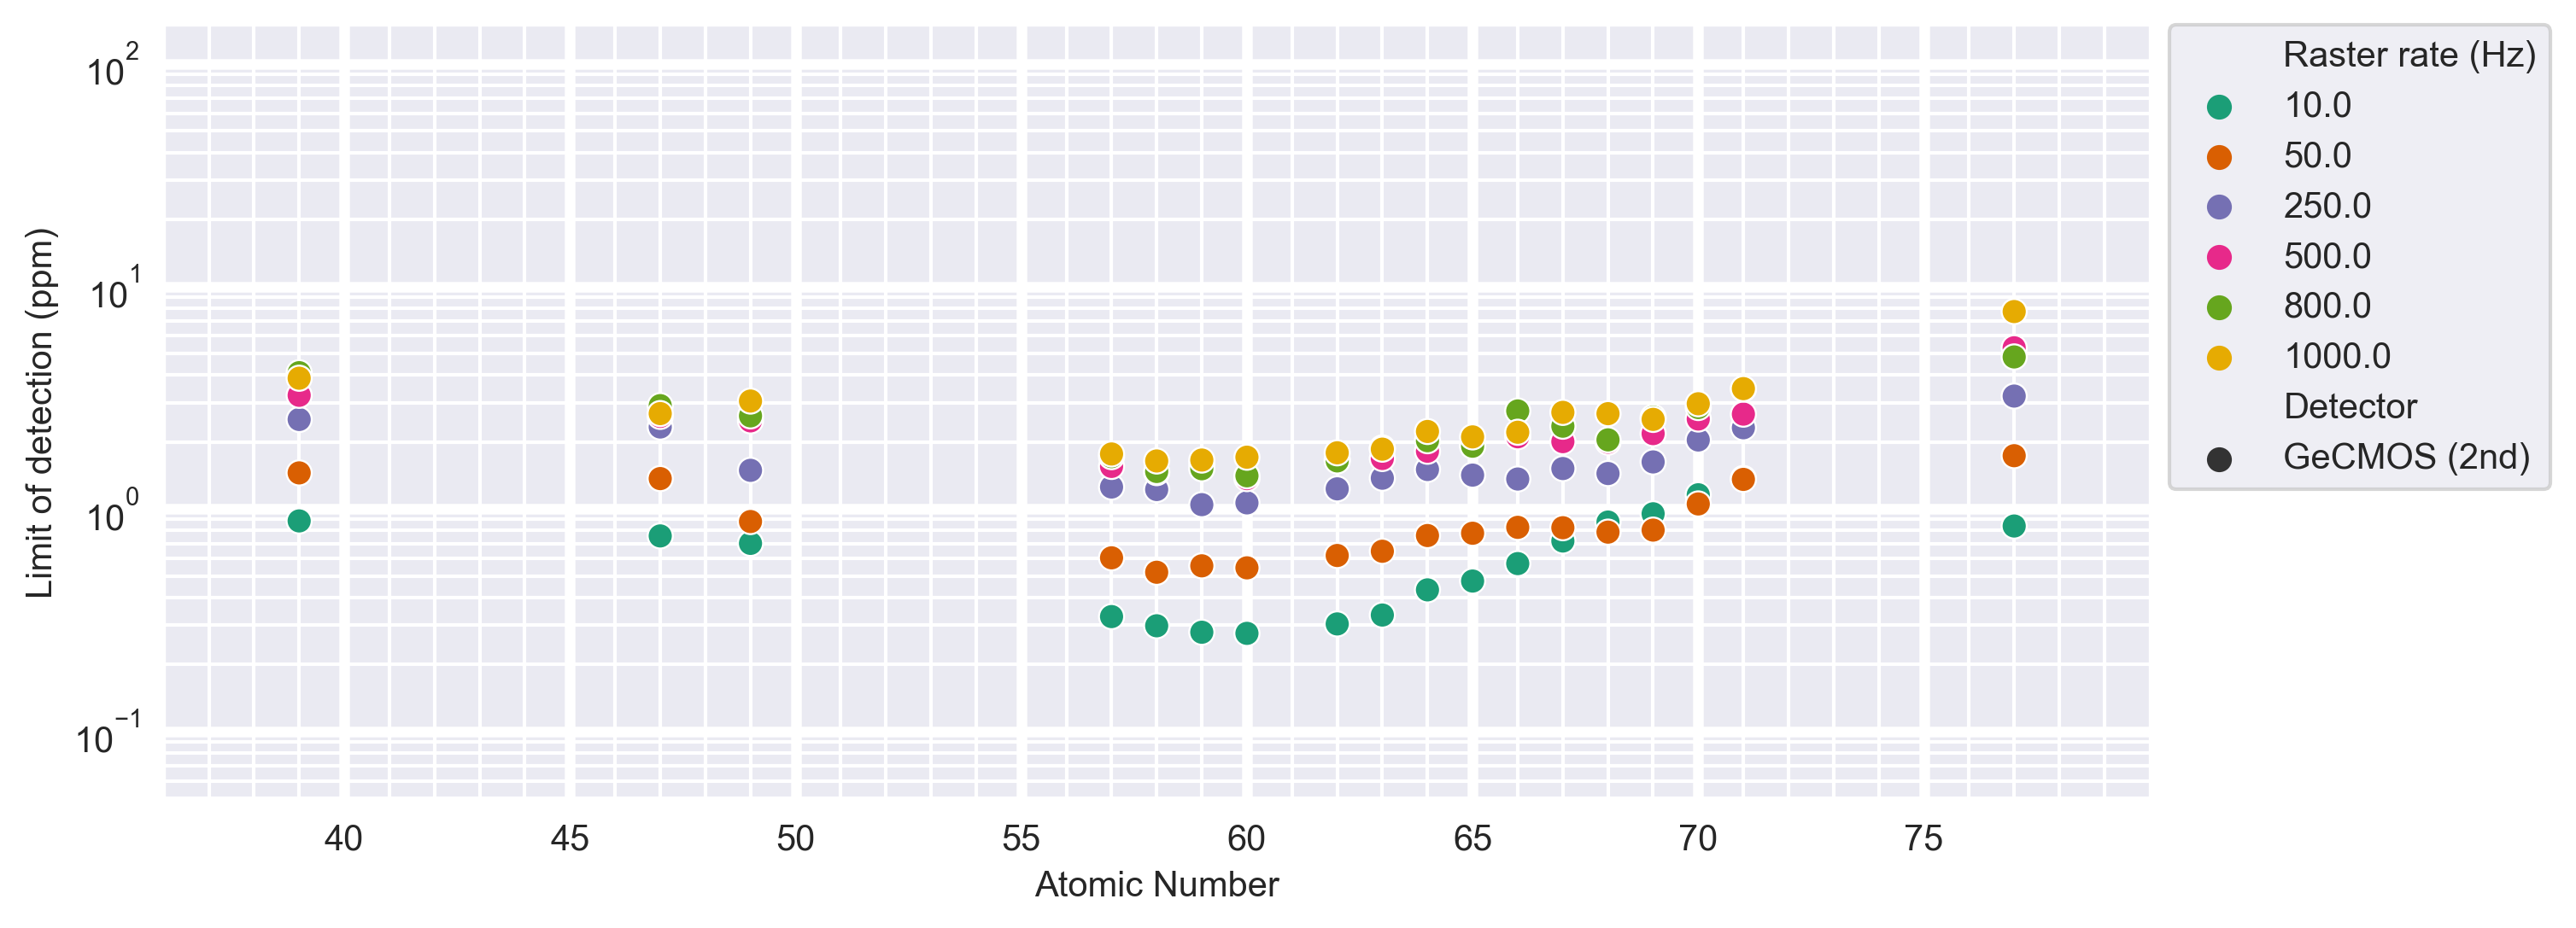

In [29]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.scatterplot(
    #data=df_detection_limits,
    data=df_detection_limits[df_detection_limits['Detector'].isin(['GeCMOS (2nd)'])],
    x='AtomicNumber',
    y='lob_concentration',
    hue='Raster rate (Hz)',
    palette='Dark2',
    style='Detector',  
    ax=ax,
    s=50
)

#Set y to log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
ax.set(yscale="log")
ax.set_ylim([0.05,150])
#ax.yaxis.set_major_formatter(ScalarFormatter())

ax.set_xticks(list(range(35, 80, 5)))
ax.set_xticks(list(range(35, 80, 1)), minor=True)
ax.set_xlim([36,80])

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Atomic Number')
plt.ylabel('Limit of detection (ppm)')

plt.show()

In [30]:
df1 = df_detection_limits[df_detection_limits['Detector'] == 'SDD']
df2 = df_detection_limits[df_detection_limits['Detector'] == 'GeCMOS']
df3 = df_detection_limits[df_detection_limits['Detector'] == 'GeCMOS (2nd)']

In [31]:
for element in df1['Symbol']:
    sdd = df1.lob_concentration[df1['Symbol'] == element].iloc[0]
    gecmos = df2.lob_concentration[df2['Symbol'] == element].iloc[0]
    gecmos2 = df3.lob_concentration[df3['Symbol'] == element].iloc[0]

    print(element, sdd/gecmos, sdd/gecmos2)

Y 0.04001688409345466 0.36185335592316153
Ag 0.4358746765245334 1.297735914567467
In 0.07739651260224505 0.3619774354656644
La 0.8100671145834918 2.8991386146244467
Ce 1.1958662812045189 3.8664412124770218
Pr 1.2875367020014492 4.293692777763124
Nd 1.4135443690688214 4.285782320911471
Sm 2.377153329253657 3.978647422576911
Eu 2.4199952945802097 3.7198792922110506
Gd 1.8936178396305734 2.9633988245153304
Tb 2.1067222254626525 3.2491054387246825
Dy 1.5077335041899167 2.15534370309013
Ho 1.4047671613198767 1.4755208138760367
Er 2.1755752578347427 2.095605614845547
Tm 2.6476535596417285 2.4784358027621662
Yb 2.9296900971647917 2.5758012662926872
Lu 3.5422131744452123 2.8609947078525804
Ir 0.2393328424513521 2.5723247875023887


In [32]:
df2[['Symbol', 'lob_concentration']]

Symbol  lob_concentration
18      Y       7.989662e+00
19     Ag       2.252322e+00
20     In       3.275693e+00
21     La       1.174804e+00
22     Ce       9.648977e-01
23     Pr       9.309137e-01
24     Nd       8.366522e-01
25     Sm       5.092025e-01
26     Eu       5.127190e-01
27     Gd       6.773755e-01
28     Tb       7.314024e-01
29     Dy       8.120901e-01
30     Ho       7.539296e-01
31     Er       8.411061e-01
32     Tm       8.905395e-01
33     Yb       1.018398e+00
34     Lu       1.107653e+00
35     Ir       9.009886e+00
36      Y       1.425831e+02
37     Ag       3.934955e+01
38     In       2.171000e+03
39     La       1.174141e+01
40     Ce       9.834907e+00
41     Pr       9.177277e+00
42     Nd       8.481283e+00
43     Sm       5.584527e+00
44     Eu       5.772766e+00
45     Gd       7.779170e+00
46     Tb       9.659884e+00
47     Dy       1.050027e+01
48     Ho       1.294980e+01
49     Er       1.624751e+01
50     Tm       1.528610e+01
51     Yb       1.579609e+01
52     Lu       1.551038e+01
53     Ir       3.032196e+02
54      Y       1.558709e+04
55     Ag       2.536306e+03
56     In       1.910305e+06
57     La       1.626403e+02
58     Ce       1.209343e+02
59     Pr       1.091757e+02
60     Nd       1.013392e+02
61     Sm       6.529564e+01
62     Eu       7.283500e+01
63     Gd       1.083836e+02
64     Tb       1.788838e+02
65     Dy       2.431140e+02
66     Ho       5.732924e+02
67     Er       8.643968e+02
68     Tm       7.166458e+02
69     Yb       6.666398e+02
70     Lu       6.628565e+02
71     Ir       5.346947e+04